##  AllLife Bank
##  Personal Loan Campaign Modeling


    Brian Hall
    DSBA - Project 4
    06/17/2021
    
## Problem
AllLife Bank would like to rapidly increase the amount of interest on personal loans by converting existing liability  customers (depositors) to personal load customers while maintaining them as depositors.  In a previous campaign the bank showed a 9% success rate for converting depositors to personal loan customers. 
    
## Objective
Utilizing data obtained from the previous successful campaign we will build machine learning models with the potential to predict what types of customers Marketing could be targeted in a new campaign.
    


## Recommendations
#### Generally, customers who use more of the banks services and  have higher averages for those services were more likely to have accepted a personal loan. This makes some sense as most of these customers have higher debt with AllLife Bank and may be more willing to extend that debt further. These same customers also tend to have higher incomes. 
 - For the next marketing campaign identify customers with higher education, income and larger family sizes.
 - External marketing campaigns to attract those with higher education, incomes and family sizes could bring in more customers who would be liability customers as well as personal loan customers. 
 
- Target incomes above 100k
- Target CCAvg > 3.5k
- Target customers with CD_Accounts
- Target Mortgages above 200K
- Target those who do not use Online banking facilities
- Target those who do not have Securities Account
- Examine customers in Santa Clara County more closely and possibly market heavier to them.
- Marketing other services, such as CD_Accoutns, could increase willingness to accept a personal loan
- Extend the types of data used to predict personal loan acceptance - such as spending patterns, savings & balances for other services

## Data    
Data has been provided via CSV (Loan_Modelling.csv  |  201k)
    
The data is assumed to be a random subset of customers targeted during a previous marketing campaign.

* ID: Customer ID
* Age: Customer’s age in completed years
* Experience: #years of professional experience
* Income: Annual income of the customer (in thousand dollars)
* ZIPCode: Home Address ZIP code.
* Family: the Family size of the customer
* CCAvg: Average spending on credit cards per month (in thousand dollars)
* Education: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
* Mortgage: Value of house mortgage if any. (in thousand dollars)
* Personal_Loan: Did this customer accept the personal loan offered in the last campaign?
* Securities_Account: Does the customer have securities account with the bank?
* CD_Account: Does the customer have a certificate of deposit (CD) account with the bank?
* Online: Do customers use internet banking facilities?
* CreditCard: Does the customer use a credit card issued by any other Bank (excluding All life Bank)?

A mix of continuous and binned variables were used for training models.  These are documented in the notebook.

## Model Observations
#### The best performing model could predict liability customers that would accept a personal loan 89.04% of the time
#### 22 models trained with F1 Score as the metric
#### Best perfroming model was - Decision Tree Post Pruned.   Results - Train F1 of 0.9132  & Test F1 of 0.8904
During EDA and feature engineering the decision was made to make 2 versions of the sample set for training.

1. Maintain continuous variables
2. Binning continuous variables
- Both sets were trained using SKLearn - Logistic Regression (solvers - newton-cg & liblinear) - **4 models**
- Both sets were trained with StatsModel - Logistic Regression (reducing complexity with VIF & P Value) -  **5 models**
- Best results from StatsModel (logit5) was tuned with various thresholds (ROC-AUC calculated & recall / precision plot) - **8 Models**
- Decision Tree training used Binned set with Hyper Parameter Tuning (GridSearchCV) & Cost Complexity Pruning - **5 models**

`note` - Initial sample set could be considered imbalanced with only 9.6% of data representing target variable, no oversampling was performed

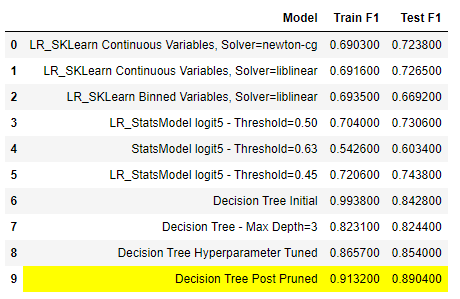

#### Significant Variables from Logistic Regression

Income, Family, CCAvg, Education, Securities_Account, CD_Account, Online, CreditCard

#### Observations on coefficient change odds
1 unit change in feature if all other features remain constant:
- Income will increase the odds of someone accepting a personal loan by 5.66% 
- CCAvg will increase the odds of someone accepting a personal loan by 11.33% 
- Securities_Account will decrease the odds of someone accepting a personal loan by 67.7% 
- Online will decrease the odds of someone accepting a personal loan by 64.5%

#### Decision Tree Gini Importance for features
- Education is the most important feature, with Income & Family being next.
- Most features other than County & Mortgage are showing some level of importance in this model.  This would likely be a better generalized model when new data is presented.

#### EDA of missed predictions observations
**No patterns stand out.**  Some features do initially stand out with higher or lower percentages for the misses, however when compared to the EDA from the original sample we find that the misses patterns closely match those for the original sample.


### Import Libraries and Global Options

In [1]:
# Import Libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox, f_oneway
import seaborn as sns
import warnings
#from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
import pylab
import scipy.stats as stats
import statsmodels.stats.api as sms
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import f1_score,accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")

%matplotlib inline

# Removes the limit from the number of displayed columns and rows.
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', 200)

### Retrieve, Examine and Prepare Data

In [2]:
#Read in data and sample
ldf = pd.read_csv("Loan_Modelling.csv", index_col=0)
print(f'There are {ldf.shape[0]} rows and {ldf.shape[1]} columns.')  # f-string

np.random.seed(2021)
ldf.sample(n=10)

There are 5000 rows and 13 columns.


,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
ID,,,,,,,,,,,,,
1250,51,27,80,90032,1,2.60,2,0,0,0,0,1,1
1471,58,28,80,91116,2,4.50,3,0,0,0,0,0,1
2889,55,28,39,94542,3,1.00,2,0,0,0,0,1,1
4459,48,22,90,94590,2,0.80,3,205,0,0,0,0,0
4310,34,8,188,94025,1,2.90,3,0,1,0,0,1,0
1810,35,10,79,95045,4,2.10,3,0,0,1,0,1,0
4623,47,20,13,94545,3,0.67,2,0,0,0,0,1,0
3461,63,37,84,92691,4,2.40,3,0,0,0,0,1,1
389,54,30,100,95814,4,3.40,3,0,1,0,0,0,0


#### Check Data Types

In [3]:
#Examine data
ldf.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIPCode             5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal_Loan       5000 non-null   int64  
 9   Securities_Account  5000 non-null   int64  
 10  CD_Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 546.9 KB


- Age -is OK as is for now - possibly bin for dtree
- Experience -should be categorical - Binning would likely be beneficial
- Income - is OK, possible binning for dtree
- ZipCode - should be categorical, check distribution to determine bin sizes
- Family - is likely OK, check results before determining if conversion is needed
- CCAVG - Is OK as a float - Check distribution before determining if binning is needed
- Education - keep as nominal value (1-3), check if encoding needed after running model
- Mortgage - Is OK as an int - Check distribution before determining if binning is needed
- Personal_loan, Securities_Account, CD_Account, Online, CreditCard - Already a 1 or 0, no additional encoding needed - Should they be changed to categorical

Examine the variables to determine how and when to handle them

#### Check for missing or duplicate data

In [4]:
# -- Check for missing data
def findNulls(df):
    numOfNulls = df.isnull().sum().sort_values(ascending=False)
    percentOfNulls = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missingData = pd.concat([numOfNulls, percentOfNulls], axis=1, keys=['numOfNulls', 'percentOfNulls'])
    return missingData
print(findNulls(ldf))

# -- Check for duplicate rows
print('')
print('Before Duplicate Check', ldf.shape)
ldfObj = ldf
duplicateldfRow = ldfObj[ldfObj.duplicated()]
print('Duplicated Rows: ', len(duplicateldfRow))
print('')
print(duplicateldfRow)


print('')
print('After Duplicate Check', ldf.shape)

                    numOfNulls  percentOfNulls
CreditCard                   0             0.0
Online                       0             0.0
CD_Account                   0             0.0
Securities_Account           0             0.0
Personal_Loan                0             0.0
Mortgage                     0             0.0
Education                    0             0.0
CCAvg                        0             0.0
Family                       0             0.0
ZIPCode                      0             0.0
Income                       0             0.0
Experience                   0             0.0
Age                          0             0.0

Before Duplicate Check (5000, 13)
Duplicated Rows:  0

Empty DataFrame
Columns: [Age, Experience, Income, ZIPCode, Family, CCAvg, Education, Mortgage, Personal_Loan, Securities_Account, CD_Account, Online, CreditCard]
Index: []

After Duplicate Check (5000, 13)


#### No missing or duplicate data

#### Experience appears to have negative values - determine how to handle

In [5]:
# Check Experience
expU = ldf.Experience.unique()
print('Number of unique values in Expereicne: ', len(expU))
ldf.Experience.value_counts()

Number of unique values in Expereicne:  47


 32    154
 20    148
 9     147
 5     146
 23    144
 35    143
 25    142
 28    138
 18    137
 19    135
 26    134
 24    131
 3     129
 14    127
 16    127
 30    126
 34    125
 27    125
 17    125
 29    124
 22    124
 7     121
 8     119
 6     119
 15    119
 10    118
 33    117
 13    117
 11    116
 37    116
 36    114
 21    113
 4     113
 31    104
 12    102
 38     88
 39     85
 2      85
 1      74
 0      66
 40     57
 41     43
-1      33
-2      15
 42      8
-3       4
 43      3
Name: Experience, dtype: int64

- Experience has 52 negative numbers that need to be handled before moving forward.
- Experience has 47 unique entries and will likely benefit from binning.  check the distribution for potential cut points
- Look for other attributes around Experience negative numbers to determine how to impute

In [6]:
#Look for other attributes around Experience negative numbers to determine how to impute
ldf.sort_values(['Experience', 'Income']).head(100)

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
ID,,,,,,,,,,,,,
3627,24,-3,28,90089,4,1.00,3,0,0,0,0,0,0
4515,24,-3,41,91768,4,1.00,3,0,0,0,0,1,0
2619,23,-3,55,92704,3,2.40,2,145,0,0,0,1,0
4286,23,-3,149,93555,2,7.20,1,0,0,0,0,1,0
4482,25,-2,35,95045,4,1.00,3,0,0,0,0,1,0
2718,23,-2,45,95422,4,0.60,2,0,0,0,0,1,1
452,28,-2,48,94132,2,1.75,3,89,0,0,0,1,0
3797,24,-2,50,94920,3,2.40,2,0,0,1,0,0,0
316,24,-2,51,90630,3,0.30,3,0,0,0,0,1,0


Income and age for negative Experience values seem to be in range for to what would be expected for the same positive values

#### We will impute by keeping the absolute of the values

In [7]:
ldf1 = ldf.copy()

In [8]:
# Remove negative numbers from Expereince by applying the abs() function
ldf1[['Experience']] = ldf1[['Experience']].apply(lambda x: abs(x))

In [9]:
ldf1.sort_values(['Experience', 'Income']).head()

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
ID,,,,,,,,,,,,,
4944,26,0,12,96003,1,0.1,2,0,0,0,0,1,0
467,25,0,13,91342,2,0.9,3,0,0,0,0,1,0
2242,26,0,14,94301,4,0.4,1,94,0,0,0,1,0
4713,25,0,14,94309,2,0.9,3,0,0,0,0,0,1
157,26,0,15,92131,4,0.4,1,0,0,0,0,0,1


#### Convert Family, Education, Personal_loan, Securities_Account, CD_Account, Online, CreditCard to CATEGORICAL

In [10]:
# Convert identified variables to categorical
ldf1 = ldf1.astype({"Family":'category', "Education": 'category', "Personal_Loan":'category', "Securities_Account":'category',
                   "CD_Account":'category', "Online":'category', "CreditCard":'category'})
ldf1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Experience          5000 non-null   int64   
 2   Income              5000 non-null   int64   
 3   ZIPCode             5000 non-null   int64   
 4   Family              5000 non-null   category
 5   CCAvg               5000 non-null   float64 
 6   Education           5000 non-null   category
 7   Mortgage            5000 non-null   int64   
 8   Personal_Loan       5000 non-null   category
 9   Securities_Account  5000 non-null   category
 10  CD_Account          5000 non-null   category
 11  Online              5000 non-null   category
 12  CreditCard          5000 non-null   category
dtypes: category(7), float64(1), int64(5)
memory usage: 308.4 KB


### Examine the data

In [11]:
ldf1.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,5000.0,NaN,NaN,NaN,45.338400,11.463166,23.0,35.0,45.0,55.0,67.0
Experience,5000.0,NaN,NaN,NaN,20.134600,11.415189,0.0,10.0,20.0,30.0,43.0
Income,5000.0,NaN,NaN,NaN,73.774200,46.033729,8.0,39.0,64.0,98.0,224.0
ZIPCode,5000.0,NaN,NaN,NaN,93169.257000,1759.455086,90005.0,91911.0,93437.0,94608.0,96651.0
Family,5000.0,4.0,1.0,1472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CCAvg,5000.0,NaN,NaN,NaN,1.937938,1.747659,0.0,0.7,1.5,2.5,10.0
Education,5000.0,3.0,1.0,2096.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mortgage,5000.0,NaN,NaN,NaN,56.498800,101.713802,0.0,0.0,0.0,101.0,635.0
Personal_Loan,5000.0,2.0,0.0,4520.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Securities_Account,5000.0,2.0,0.0,4478.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Age mean is 45.3 with a range of 23 - 67
- Experience mean is 20.1 years with a range of 0 to 43 
- Income mean is 73.3K with a range of 8K to 224K
- Zipcode - Needs to be binned, possibly by region or state.  Add region and state to dataframe and determine how to bin
- Family - 4 unique categories with 1 being most common - Interesting that there are no 0's, could 1 indicate self?
- CCAvg - mean is 1.9K with a range of 0 to 10K
- Education - 3 unique categories with 1 being the most common
- Mortgage - mean 56.5K with a range of 0 to 635K
- Personal_Loan - yea or no with no being the most common
- Securities_Account - yes or no with no being the most common
- CD_Account - yes or no with no being the most common
- Online - yes or no with yes being the most common
- CreditCard - yes or no with no being the most common

### ZipCode needs to be checked and binned

In [12]:
#Import us zipcode search engine - use simple zipcode to decrease file size - all we should need is state / region
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True) # set simple_zipcode data to decrease download size and time
zipcode = search.by_zipcode("95521")
print(zipcode)
print(zipcode.state)
print(zipcode.county)
print(zipcode.major_city)
print(zipcode.common_city_list)

SimpleZipcode(zipcode='95521', zipcode_type='Standard', major_city='Arcata', post_office_city='Arcata, CA', common_city_list=['Arcata', 'Mc Kinleyville', 'Mckinleyville'], county='Humboldt County', state='CA', lat=40.8, lng=-124.1, timezone='Pacific', radius_in_miles=9.0, area_code_list=['707'], population=20199, population_density=378.0, land_area_in_sqmi=53.5, water_area_in_sqmi=17.71, housing_units=9068, occupied_housing_units=8643, median_home_value=345100, median_household_income=34046, bounds_west=-124.244378, bounds_east=-123.888979, bounds_north=40.956031, bounds_south=40.751948)
CA
Humboldt County
Arcata
['Arcata', 'Mc Kinleyville', 'Mckinleyville']


In [13]:
# Define functions to retrieve State, County & City
def getState(zCode):
    zipcode = search.by_zipcode(zCode)
    return str(zipcode.state)

def getCounty(zCode):
    zipcode = search.by_zipcode(zCode)
    return str(zipcode.county)

def getCity(zCode):
    zipcode = search.by_zipcode(zCode)
    return str(zipcode.major_city)


In [14]:
# Apply zipcode lookup Functions to dataframe
ldf1[['State']] = ldf1['ZIPCode'].apply(lambda x: (getState(x)))
ldf1[['County']] = ldf1['ZIPCode'].apply(lambda x: (getCounty(x)))
ldf1[['City']] = ldf1['ZIPCode'].apply(lambda x: (getCity(x)))


#### Check Zipcode lookup success

#### Check distributions to see if / how to bin zipcodes 

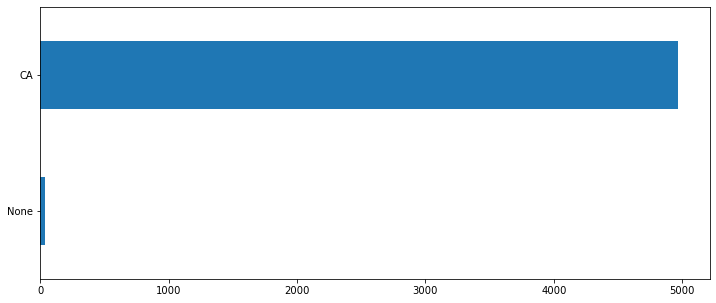

In [15]:
# Plot state
plt.figure(figsize=(12,5))
ldf1['State'].value_counts().plot(kind='barh').invert_yaxis()

#### All locations are in CA, however there does seem to be  missing values for locations, likely due to zipcode lookup error
#### Determine how to impute after looking at distributions

In [16]:
print('Observations missing location: ', ldf1[ldf1.State != 'CA'].value_counts().sum())
ldf1[ldf1.State != 'CA']

Observations missing location:  34


,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,State,County,City
ID,,,,,,,,,,,,,,,,
107,43,17,69,92717,4,2.90,1,0,0,0,0,1,1,None,None,None
173,38,13,171,92717,2,7.80,1,0,0,0,0,1,0,None,None,None
185,52,26,63,92717,2,1.50,2,0,0,1,0,1,0,None,None,None
322,44,20,101,92717,3,4.40,2,82,1,0,0,0,0,None,None,None
367,50,24,35,92717,1,0.30,3,0,0,0,0,1,0,None,None,None
385,51,25,21,93077,4,0.60,3,0,0,0,0,1,1,None,None,None
469,34,10,21,92634,1,0.50,3,0,0,0,0,1,0,None,None,None
477,60,34,53,92717,1,0.80,2,0,0,1,0,0,1,None,None,None
631,32,7,35,96651,3,1.30,1,108,0,0,0,0,1,None,None,None


#### There are 34 observations missing State, County & City

Number of counties:  39


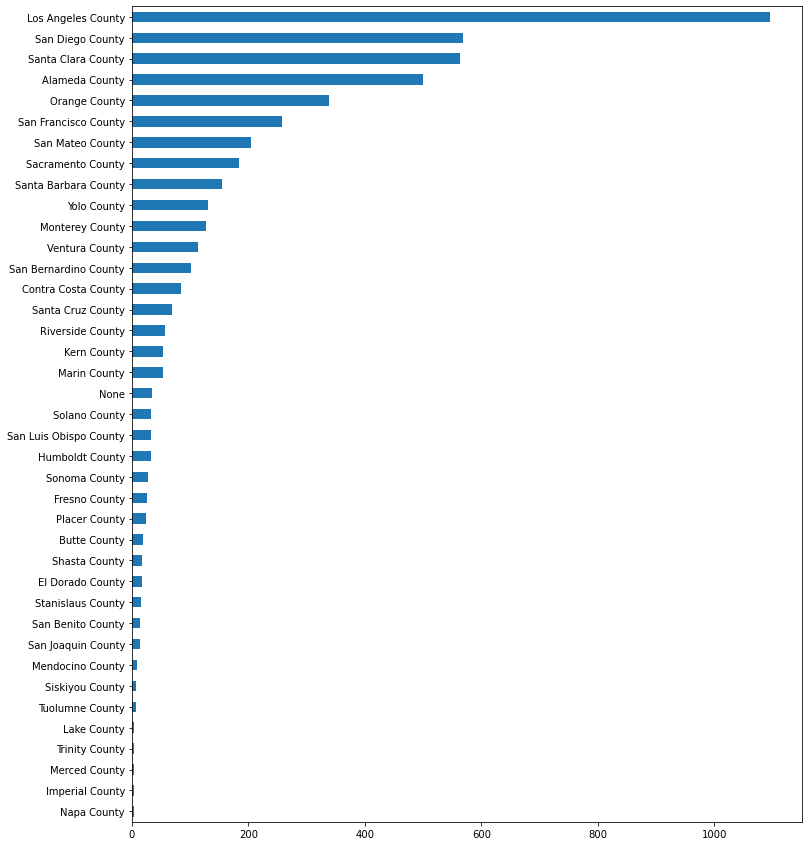

In [17]:
# Plot county
counties = ldf1['County'].unique()
print('Number of counties: ', len(counties))
plt.figure(figsize=(12,15))
ldf1['County'].value_counts().plot(kind='barh').invert_yaxis()

In [18]:
# count City
cities = ldf1['City'].unique()
print('Number of cities: ', len(cities))


Number of cities:  245


#### There are 1 states, 39 counties and 245 Cities with 34 entries missing locations
#### We will bin by county with counties having  a cut off point being binned into 'County_Other'

Check counts for a good cut off point

In [19]:
# Add the number of observations for each county to the df
ldf1[['obsInCnty']] = ldf1['County'].apply(lambda x: ldf1.County[ldf1.County == x].count())
ldf1.sample(10)

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,State,County,City,obsInCnty
ID,,,,,,,,,,,,,,,,,
4695,39,13,25,94132,2,0.8,3,0,0,0,0,0,0,CA,San Francisco County,San Francisco,257
3036,50,24,31,95054,1,0.3,3,0,0,0,0,0,0,CA,Santa Clara County,Santa Clara,563
2845,60,34,64,95014,3,2.2,3,0,0,0,0,0,0,CA,Santa Clara County,Cupertino,563
2341,33,9,44,94112,1,1.2,1,0,0,0,0,0,0,CA,San Francisco County,San Francisco,257
4023,35,5,81,94234,4,4.0,3,0,0,0,0,1,0,CA,Sacramento County,Sacramento,184
2886,57,31,113,91711,4,0.6,3,327,1,0,0,1,0,CA,Los Angeles County,Claremont,1095
68,53,23,45,95123,4,2.0,3,132,0,1,0,0,0,CA,Santa Clara County,San Jose,563
4877,44,19,142,95054,1,1.5,3,0,1,0,0,0,0,CA,Santa Clara County,Santa Clara,563
4162,32,8,61,94703,3,2.6,2,0,0,0,0,0,0,CA,Alameda County,Berkeley,500


Cut off point for Counties will be 50

In [20]:
# Create a new working copy of the df
ldf2 = ldf1.copy()
ldf2.head(2)

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,State,County,City,obsInCnty
ID,,,,,,,,,,,,,,,,,
1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0,CA,Los Angeles County,Pasadena,1095
2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0,CA,Los Angeles County,Los Angeles,1095


### We will bin all counties with observations less than 50 to 'Other_County'

In [21]:
#Replace counties with less than 50 observations with County_Other
ldf2.loc[ldf2['obsInCnty'] < 50, 'County'] = 'County_Other'
ldf2.sample(50)

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,State,County,City,obsInCnty
ID,,,,,,,,,,,,,,,,,
4149,46,22,80,95747,4,2.00,3,0,0,0,0,1,0,CA,County_Other,Roseville,24
502,50,26,39,90640,3,1.90,2,0,0,0,0,1,0,CA,Los Angeles County,Montebello,1095
1217,50,25,84,91107,1,1.30,3,0,0,1,0,1,0,CA,Los Angeles County,Pasadena,1095
815,33,8,45,93943,2,0.10,1,0,0,0,0,0,1,CA,Monterey County,Monterey,128
684,40,16,82,91311,1,3.60,2,0,0,0,0,0,0,CA,Los Angeles County,Chatsworth,1095
3153,40,15,83,90275,1,1.00,3,0,0,0,0,0,0,CA,Los Angeles County,Rancho Palos Verdes,1095
1545,39,15,24,92123,1,1.00,1,116,0,0,0,1,1,CA,San Diego County,San Diego,568
3384,46,22,135,95135,3,4.10,1,213,1,0,0,1,0,CA,Santa Clara County,San Jose,563
1766,26,0,149,95051,2,7.20,1,154,0,0,0,0,0,CA,Santa Clara County,Santa Clara,563


Number of counties:  19


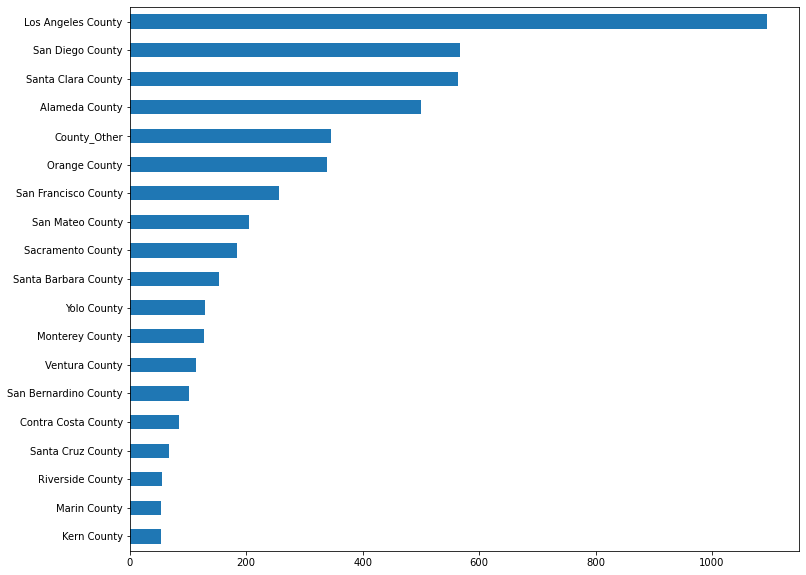

In [22]:
# Plot county
counties = ldf2['County'].unique()
print('Number of counties: ', len(counties))
plt.figure(figsize=(12,10))
ldf2['County'].value_counts().plot(kind='barh').invert_yaxis()

#### this removes 20 counties and places Other_Counties closer to the center of the distribution

#### Cutting observation counts at:
- 50 -kept 19 counties with other_county being 5th
- 100 -kept 14 counties with other_county being 2nd
- 200 -kept 8 counties with other_county being 1st



# EDA & Pre-Processing

### UniVariate

In [23]:
# looking at value counts for non-numeric features

num_to_display = 35  # defining this up here so it's easy to change later if I want
for colname in ldf2.dtypes[ldf2.dtypes == 'category'].index:
    val_counts = ldf2[colname].value_counts(dropna=False)  # i want to see NA counts
    print(val_counts[:num_to_display])
    if len(val_counts) > num_to_display:
        print(f'Only displaying first {num_to_display} of {len(val_counts)} values.')
    print('\n') # just for more space between 

1    1472
2    1296
4    1222
3    1010
Name: Family, dtype: int64


1    2096
3    1501
2    1403
Name: Education, dtype: int64


0    4520
1     480
Name: Personal_Loan, dtype: int64


0    4478
1     522
Name: Securities_Account, dtype: int64


0    4698
1     302
Name: CD_Account, dtype: int64


1    2984
0    2016
Name: Online, dtype: int64


0    3530
1    1470
Name: CreditCard, dtype: int64




#### Observations
Personal Loan accounts for ~10% of the total we will want to watch the split carefully


In [24]:
# Function to create histogram and boxplot for numerical attributes
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2,
                                           sharex = True,
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           )
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet') 
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,palette="winter") if bins else sns.distplot(feature, kde=False, ax=ax_hist2) 
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') 
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') 

# Function to create percentages for count plots - categorical attributes
def perc_on_bar(plot, feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    total = len(feature) # length of the column
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) 
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()           
        ax.annotate(percentage, (x, y), size = 12) 
    plt.show() 

In [25]:
ldf2.head(2)

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,State,County,City,obsInCnty
ID,,,,,,,,,,,,,,,,,
1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0,CA,Los Angeles County,Pasadena,1095
2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0,CA,Los Angeles County,Los Angeles,1095


### Age

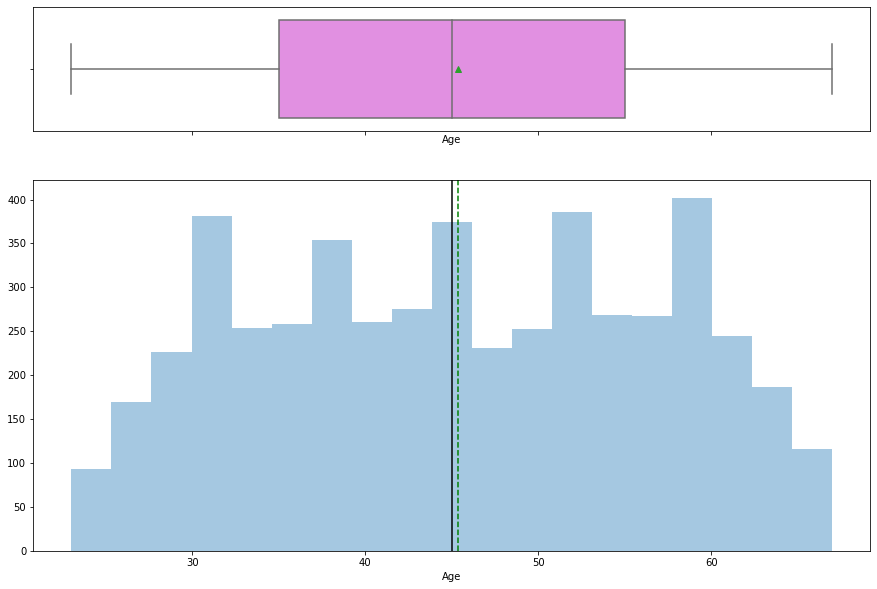

In [26]:
# Age distribution
histogram_boxplot(ldf2["Age"])


#### Observation
Age has a fairly normal distribution with no apparent outliers - Will keep as is for models unless outcomes dictate binning, etc

### Experience

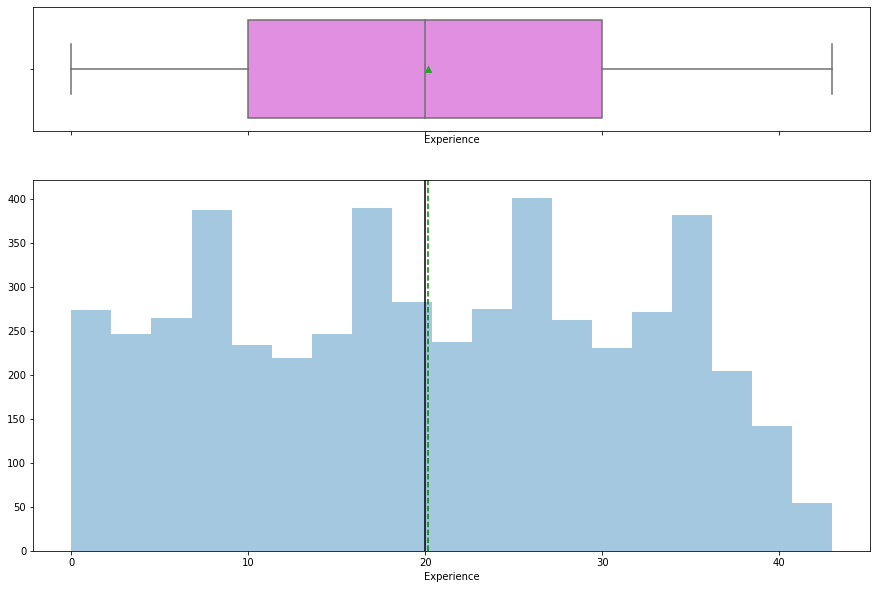

In [27]:
# Age distribution
histogram_boxplot(ldf2["Experience"])


#### Observation
Experience seems to be a normal distribution with no apparent outliers

Experience drops fairly quickly after 35 years 
#### To help normalize scale and reduce complexity we will bin Experience
#### Given the fairly even distribution we will bin experience into 4 equal parts 
- Low - 0-10
- Medium - 11-20
- High - 21-30
- Very High - 31+

In [28]:
# Bin experience
cut_labels = ['Low', 'Medium', 'High', 'Very High']
cut_bins = [-1, 10, 20, 30, np.inf]
ldf2['ExpBin'] = pd.cut(ldf2['Experience'], bins=cut_bins, labels=cut_labels)

In [29]:
ldf2.sample(10)

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,State,County,City,obsInCnty,ExpBin
ID,,,,,,,,,,,,,,,,,,
3853,33,7,15,92152,1,0.40,2,82,0,1,1,1,1,CA,San Diego County,San Diego,568,Low
439,58,32,113,93943,2,3.80,2,119,1,0,1,1,1,CA,Monterey County,Monterey,128,Very High
3286,38,13,65,91706,3,0.70,2,0,0,0,0,1,0,CA,Los Angeles County,Baldwin Park,1095,Medium
3864,34,10,21,91770,4,0.70,2,0,0,0,0,1,0,CA,Los Angeles County,Rosemead,1095,Low
4820,32,6,41,95833,3,0.90,1,179,0,0,0,0,0,CA,Sacramento County,Sacramento,184,Low
446,58,32,65,94590,3,2.20,3,0,0,0,0,1,0,CA,County_Other,Vallejo,33,Very High
2429,39,12,108,92717,4,3.67,2,301,1,0,0,0,1,None,County_Other,None,34,Medium
474,64,39,182,93955,1,1.20,2,547,1,0,0,1,0,CA,Monterey County,Seaside,128,Very High
3961,62,37,48,92028,3,2.20,1,0,0,0,0,0,0,CA,San Diego County,Fallbrook,568,Very High


In [30]:
# Check that experience of 0 was correctly cut
ldf2[ldf2.Experience == 0].head(2)

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,State,County,City,obsInCnty,ExpBin
ID,,,,,,,,,,,,,,,,,,
106,24,0,35,94704,3,0.1,2,0,0,1,0,1,0,CA,Alameda County,Berkeley,500,Low
152,26,0,132,92834,3,6.5,3,0,1,0,0,0,1,CA,Orange County,Fullerton,339,Low


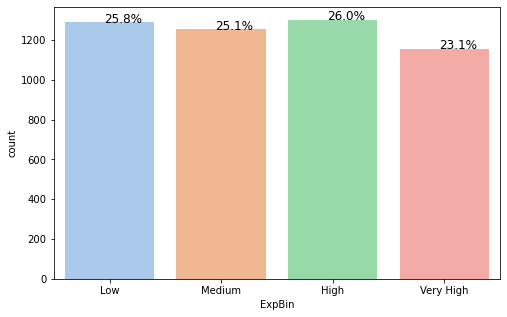

In [31]:
# plot ExpBin
plt.figure(figsize=(8,5))
ax = sns.countplot(ldf2["ExpBin"],palette='pastel')
perc_on_bar(ax,ldf2["ExpBin"])

#### Observation
Distribution across experience is surprisingly level with High experience (21-30) being the highest at 26%

It will be interesting to see how personal loans are distributed across experience

### Income
In Thousand dollars

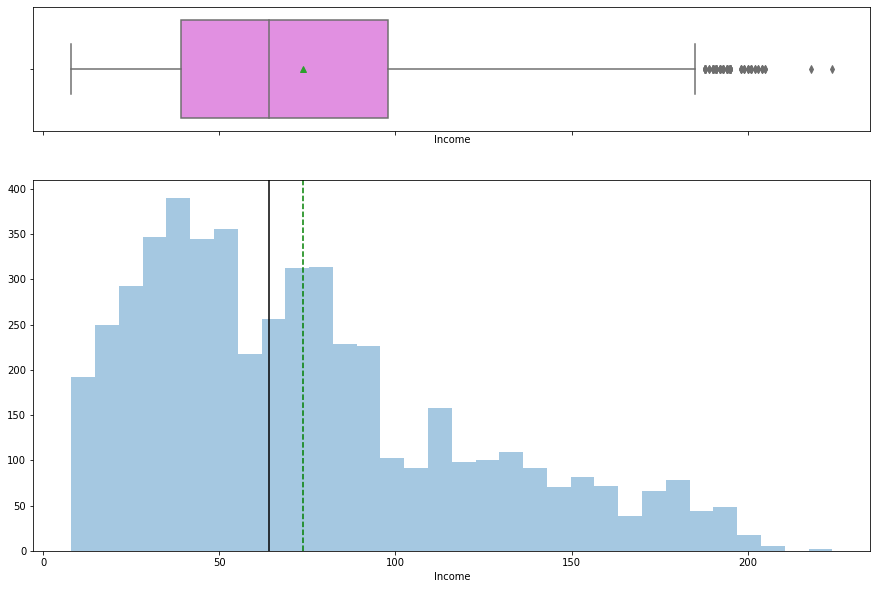

In [32]:
# Income distribution
histogram_boxplot(ldf2["Income"])

#### Observations
Income is right skewed with a number of outliers above 175k. We will want to check these to see if they need to be imputed

The majority of income falls between 10k - 90k



In [33]:
ldf2[['Income', 'Age', 'Experience', 'Education']][ldf2['Income']>200]

,Income,Age,Experience,Education
ID,,,,
527,205,26,2,1
678,204,46,21,1
788,202,45,15,3
1712,201,27,3,1
1902,201,43,19,1
2102,203,35,5,3
2279,204,30,4,1
2338,201,43,16,2
2448,201,44,19,1


In [34]:
ldf2[['Income']][ldf2['Income']<50].count()

Income    1869
dtype: int64

In [35]:
ldf2[['Income']][ldf2['Income']==0].count()

Income    0
dtype: int64

#### Observations
Minimum income is 8k

There are 16 outliers above 200k with some that are questionable when looking at age, experience and education.

However it is not impossible for there to be high incomes for tech people in that part of the country...

We will bin Income into IBins:
- 0-50 = I_0-50
- 51-75 = I_51-75
- 76-125 = I_76-125
- 126-175 = I_126-175
- 176 + = I_GT176



In [36]:
# Bin Income
cut_labels4 = ['I_0-50', 'I_51-75', 'I_76-125', 'I_126-175', 'I_GT176']
cut_bins4 = [0, 50, 75, 125, 175, np.inf]
ldf2['IBins'] = pd.cut(ldf2['Income'], bins=cut_bins4, labels=cut_labels4)

In [37]:
ldf2.head(5)

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,State,County,City,obsInCnty,ExpBin,IBins
ID,,,,,,,,,,,,,,,,,,,
1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0,CA,Los Angeles County,Pasadena,1095,Low,I_0-50
2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0,CA,Los Angeles County,Los Angeles,1095,Medium,I_0-50
3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0,CA,Alameda County,Berkeley,500,Medium,I_0-50
4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0,CA,San Francisco County,San Francisco,257,Low,I_76-125
5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1,CA,Los Angeles County,Northridge,1095,Low,I_0-50


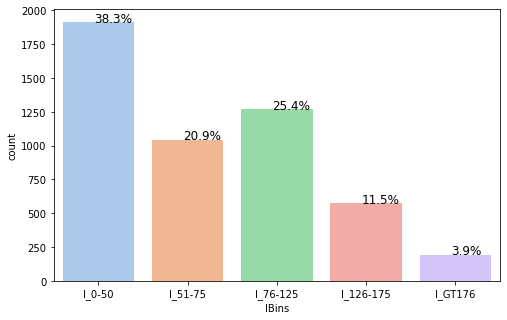

In [38]:
# plot IBins
plt.figure(figsize=(8,5))
ax = sns.countplot(ldf2["IBins"],palette='pastel')
perc_on_bar(ax,ldf2["IBins"])

### Zipcode (by county)

Number of counties:  19


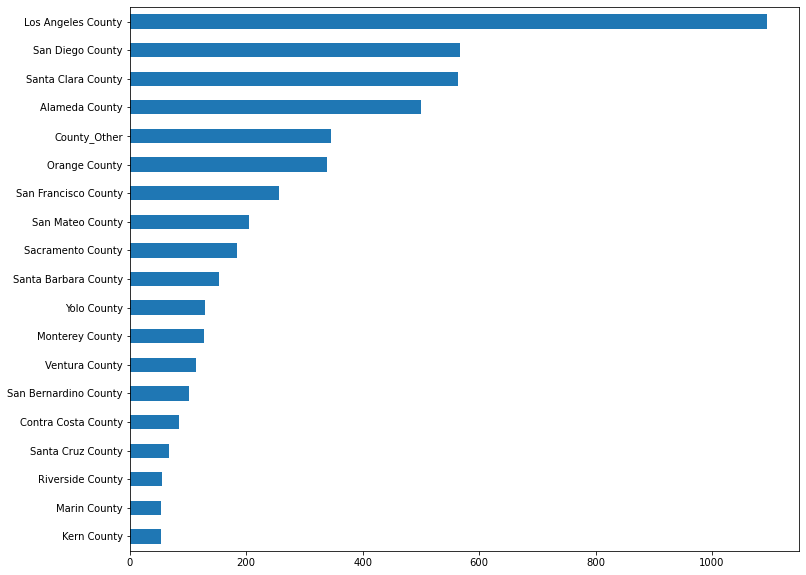

In [39]:
# Plot zipcode
counties = ldf2['County'].unique()
print('Number of counties: ', len(counties))
plt.figure(figsize=(12,10))
ldf2['County'].value_counts().plot(kind='barh').invert_yaxis()

#### Observations
LA County has the by far the largest number of customers with San Diego County and Santa Clara County being just over half of that

All counties with fewer than 50 observations have been grouped into "County_Other" which has the 5th largest number of customers

### Family

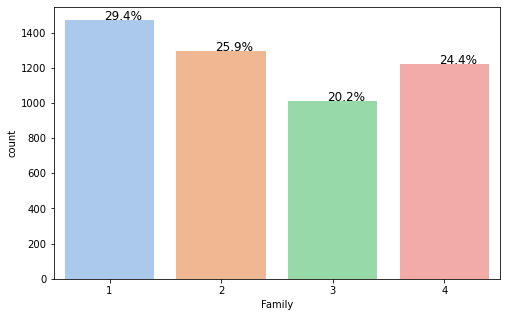

In [40]:
# plot Family
plt.figure(figsize=(8,5))
ax = sns.countplot(ldf2["Family"],palette='pastel')
perc_on_bar(ax,ldf2["Family"])

#### Observations
Family size (1-4) are all within 10% of each other.

Family size of 1 accounts for 29.4% of customers.

### CCAvg

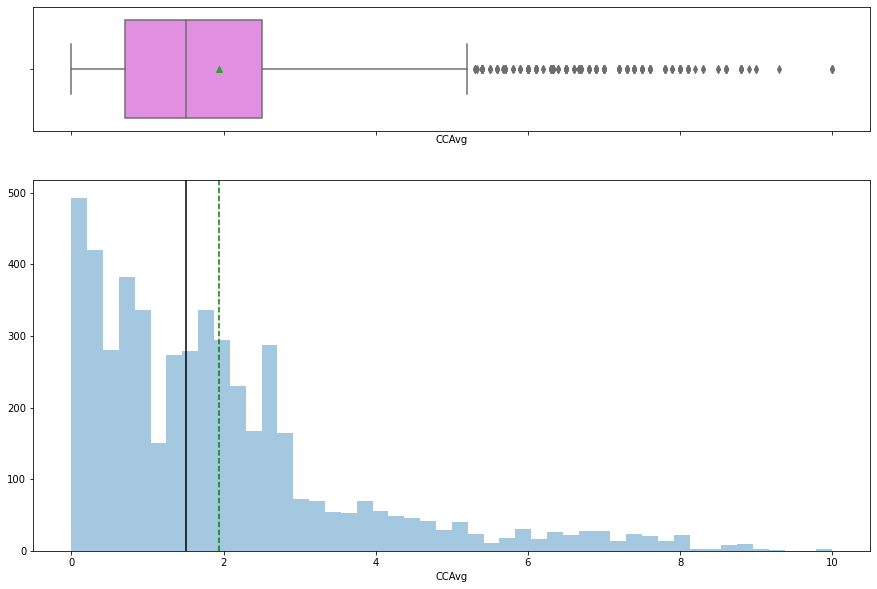

In [41]:
# CCAvg distribution
histogram_boxplot(ldf2["CCAvg"])

#### Observations
CCAvg is heavily right skewed with a large number of outliers above 5.5k with a few as high as 10k

We will want to check the outliers and determine if they need to be imputed

In [42]:
#ldf2[ldf2.CCAvg > 8.2]
ldf2[['CCAvg', 'Personal_Loan','Income', 'Experience', 'Age']][ldf2.CCAvg > 8]

,CCAvg,Personal_Loan,Income,Experience,Age
ID,,,,,
10,8.9,1,180,9,34
19,8.1,1,193,21,46
463,8.3,1,183,4,29
615,8.6,0,180,12,37
741,8.1,0,195,27,52
788,10.0,1,202,15,45
808,8.1,0,162,27,52
882,8.8,0,154,19,44
916,8.1,0,184,28,53


In [43]:
ldf2[['CCAvg', 'Personal_Loan','Income', 'Experience', 'Age']][ldf2.CCAvg <= 0.1]

,CCAvg,Personal_Loan,Income,Experience,Age
ID,,,,,
12,0.1,0,45,5,29
53,0.1,0,72,6,30
57,0.1,0,29,30,55
64,0.0,0,32,17,42
100,0.1,0,15,41,66
...,...,...,...,...,...
4910,0.1,0,25,16,41
4911,0.0,0,120,22,48
4944,0.1,0,12,0,26


#### Observations
A large portion of customers with CCAvg >= 8k have personal loans

All CCAvg >= 8k have incomes higher the 143k

There are only 3 customers with a max of 10k, all have income > 200k & all have personal loans

There is a jump from 9k to 10k with 3 customers in between

#### Overall, I hesitate to drop any of these as they seem legitimate and have heavier weight in the number of personal loans. 
- We will bin CCAvg:
- 0 = CCA_None
- 0.1 to 1 = CCA_Low
- 1.1 to 2 = CCA_Medium
- 2.1 to 4 = CCA_High
- 4.1 + = CCA_VeryHigh

In [44]:
# Bin CCAvg
cut_labels1 = ['CCA_None', 'CCA_Low', 'CCA_Medium', 'CCA_High', 'CCA_VeryHigh']
cut_bins1 = [-1, 0, 1, 2, 4, np.inf]
ldf2['CCABin'] = pd.cut(ldf2['CCAvg'], bins=cut_bins1, labels=cut_labels1)

In [45]:
ldf2[['CCAvg', 'CCABin']].sample(10)

,CCAvg,CCABin
ID,,
2124,0.1,CCA_Low
2464,0.2,CCA_Low
2974,2.9,CCA_High
2370,0.1,CCA_Low
4913,1.3,CCA_Medium
255,3.9,CCA_High
1005,2.0,CCA_Medium
1643,1.5,CCA_Medium
2213,2.7,CCA_High


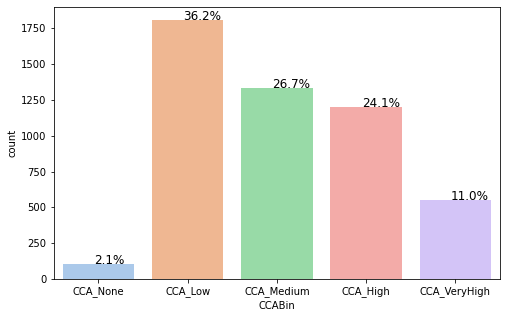

In [46]:
# plot CCABin
plt.figure(figsize=(8,5))
ax = sns.countplot(ldf2["CCABin"],palette='pastel')
perc_on_bar(ax,ldf2["CCABin"])

#### Observations
There are surprisingly few customers who have no CCAvg 2.1%

Most Customers 36.2% have a Low monthly credit card average

### Education

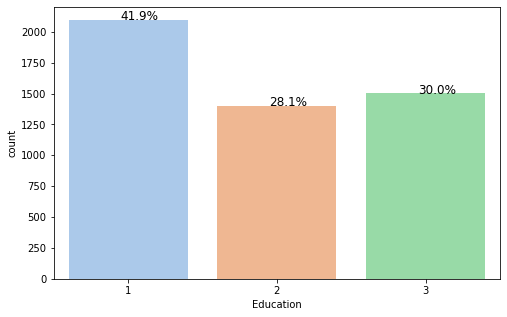

In [47]:
# plot Education
plt.figure(figsize=(8,5))
ax = sns.countplot(ldf2["Education"],palette='pastel')
perc_on_bar(ax,ldf2["Education"])

#### Observation
Most customers ~42% are undergraduate with Graduate and Advanced / Professional being roughly equal

### Mortgage
In Thousands

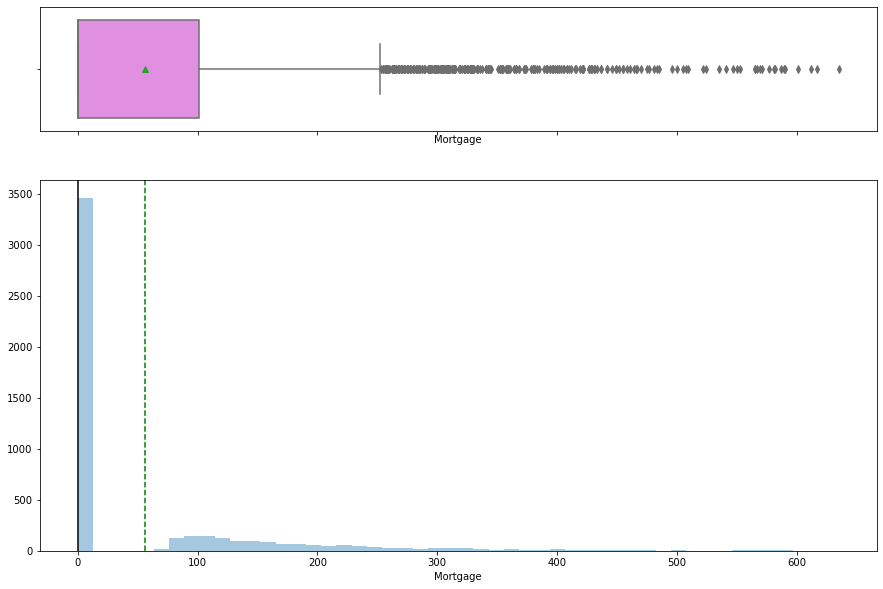

In [48]:
# Income distribution
histogram_boxplot(ldf2["Mortgage"])

In [49]:
ldf2[['Mortgage']][ldf2.Mortgage == 0].count()

Mortgage    3462
dtype: int64

#### Observations
Mortgage is extremely right skewed with a large number of outliers

3462 - ~ 69% of customers do not have a mortgage

There are no Mortgages lower than 75k


#### We will bin Mortgage into MBins:
- 0 = M_None
- 1 - 75 = M0-75
- 76 - 100 = M76-100
- 101 - 200 = M100 - 200
- 200 + = MGT200


In [50]:
# Bin Mortgage
cut_labels2 = ['M_None', 'M_0-75', 'M_76-100', 'M_101-200', 'M_GT200']
cut_bins2 = [-1, 0, 75, 100, 200, np.inf]
ldf2['MBins'] = pd.cut(ldf2['Mortgage'], bins=cut_bins2, labels=cut_labels2)

In [51]:
ldf2[['Mortgage', 'MBins']].sample(10)

,Mortgage,MBins
ID,,
131,276,M_GT200
1050,0,M_None
4421,0,M_None
89,0,M_None
2961,0,M_None
3642,0,M_None
1586,0,M_None
3383,0,M_None
4970,250,M_GT200


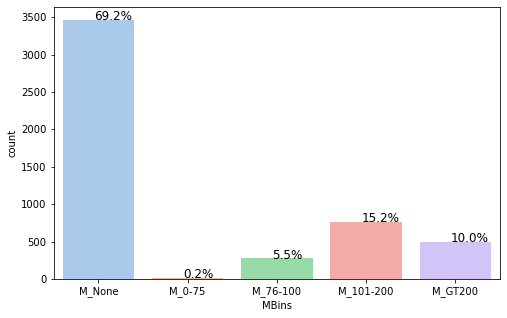

In [52]:
# plot MBins
plt.figure(figsize=(8,5))
ax = sns.countplot(ldf2["MBins"],palette='pastel')
perc_on_bar(ax,ldf2["MBins"])

### Securities_Account

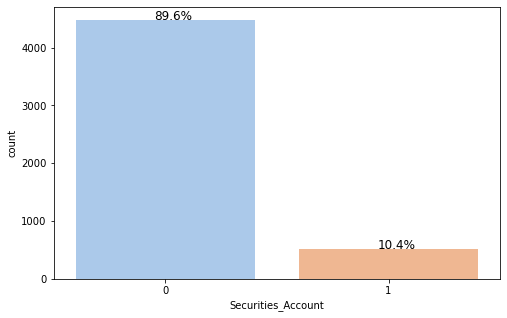

In [53]:
# plot Securities_Account
plt.figure(figsize=(8,5))
ax = sns.countplot(ldf2["Securities_Account"],palette='pastel')
perc_on_bar(ax,ldf2["Securities_Account"])

#### Observations
 Apx. 10% of customers have a securities account

### CD_Account

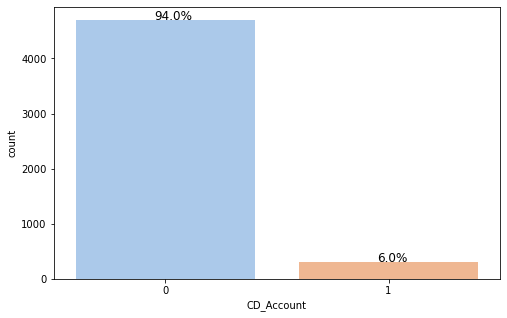

In [54]:
# plot CD_Account
plt.figure(figsize=(8,5))
ax = sns.countplot(ldf2["CD_Account"],palette='pastel')
perc_on_bar(ax,ldf2["CD_Account"])

#### Observations
Only 6% of customers have a CD_Account

### Online

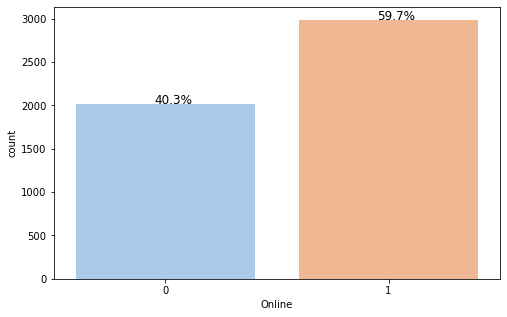

In [55]:
# plot Online
plt.figure(figsize=(8,5))
ax = sns.countplot(ldf2["Online"],palette='pastel')
perc_on_bar(ax,ldf2["Online"])

#### Observations
~60% of customers use internet banking facilities

### CreditCard

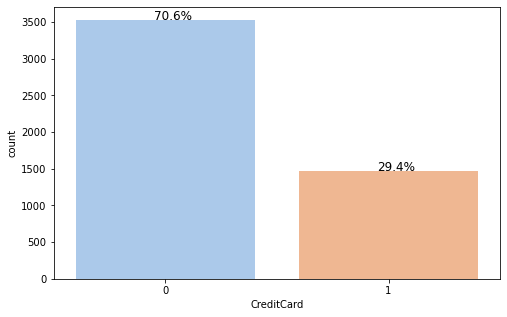

In [56]:
# plot CreditCard
plt.figure(figsize=(8,5))
ax = sns.countplot(ldf2["CreditCard"],palette='pastel')
perc_on_bar(ax,ldf2["CreditCard"])

#### Observations
~71% of customers do not have a credit card with another bank

## Personal_Loan

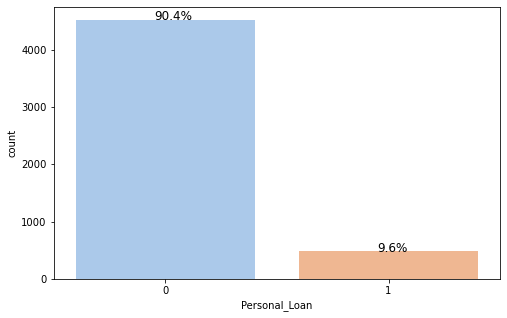

In [57]:
# plot Personal_Loan
plt.figure(figsize=(8,5))
ax = sns.countplot(ldf2["Personal_Loan"],palette='pastel')
perc_on_bar(ax,ldf2["Personal_Loan"])

#### Observations
9.6% of customers in the sample have a personal loan which approximately matches the project brief of 9% conversion rate on previous campaign

In [58]:
ldf2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Experience          5000 non-null   int64   
 2   Income              5000 non-null   int64   
 3   ZIPCode             5000 non-null   int64   
 4   Family              5000 non-null   category
 5   CCAvg               5000 non-null   float64 
 6   Education           5000 non-null   category
 7   Mortgage            5000 non-null   int64   
 8   Personal_Loan       5000 non-null   category
 9   Securities_Account  5000 non-null   category
 10  CD_Account          5000 non-null   category
 11  Online              5000 non-null   category
 12  CreditCard          5000 non-null   category
 13  State               5000 non-null   object  
 14  County              5000 non-null   object  
 15  City                5000 non-null   ob

## MultiVariate

#### Drop unneeded columns from dataset.  We will keep some of the continuous variable that were changed to categorical to see correlation, and will drop them prior to data split.

In [59]:
# Copy the Data frame before dropping columns
ldf3 = ldf2.copy()

In [60]:
ldf3.drop(["obsInCnty"],axis=1,inplace=True)
ldf3.drop(['ZIPCode'], axis=1, inplace=True)
ldf3.drop(['City'], axis=1, inplace=True)
ldf3.drop(['State'], axis=1, inplace=True)

In [61]:
ldf3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Experience          5000 non-null   int64   
 2   Income              5000 non-null   int64   
 3   Family              5000 non-null   category
 4   CCAvg               5000 non-null   float64 
 5   Education           5000 non-null   category
 6   Mortgage            5000 non-null   int64   
 7   Personal_Loan       5000 non-null   category
 8   Securities_Account  5000 non-null   category
 9   CD_Account          5000 non-null   category
 10  Online              5000 non-null   category
 11  CreditCard          5000 non-null   category
 12  County              5000 non-null   object  
 13  ExpBin              5000 non-null   category
 14  IBins               5000 non-null   category
 15  CCABin              5000 non-null   ca

In [62]:
# However we want to see correlation in graphical representation so below is function for that
def plot_corr(df, size=11):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for (i, j), z in np.ndenumerate(corr):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')


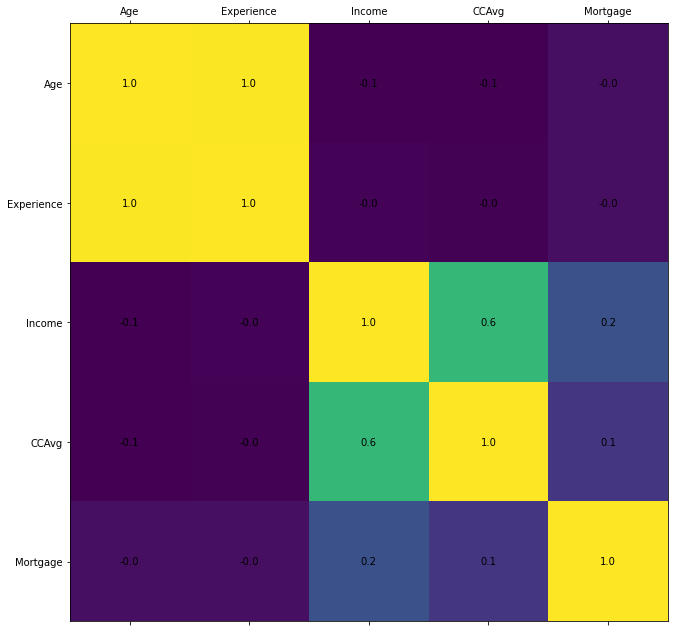

In [63]:
plot_corr(ldf3)

#### Observations
Age and Experience are showing perfect correlation, we have binned experience and will see what the outcome on the models are

CCAvg and Income show some correlation at 0.6

Otherwise the rest of the variables are showing little to no correlation

In [64]:
ldf3.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,5000,NaN,NaN,NaN,45.3384,11.4632,23,35,45,55,67
Experience,5000,NaN,NaN,NaN,20.1346,11.4152,0,10,20,30,43
Income,5000,NaN,NaN,NaN,73.7742,46.0337,8,39,64,98,224
Family,5000,4,1,1472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CCAvg,5000,NaN,NaN,NaN,1.93794,1.74766,0,0.7,1.5,2.5,10
Education,5000,3,1,2096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mortgage,5000,NaN,NaN,NaN,56.4988,101.714,0,0,0,101,635
Personal_Loan,5000,2,0,4520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Securities_Account,5000,2,0,4478,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD_Account,5000,2,0,4698,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
## Function to plot stacked bar chart
def stacked_plot(x):
    sns.set(palette="nipy_spectral")
    tab1 = pd.crosstab(x, ldf3["Personal_Loan"], margins=True)
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(x, ldf3["Personal_Loan"], normalize="index")
    tab.plot(kind="bar", stacked=True, figsize=(10, 5))
    # plt.legend(loc='lower left', frameon=False)
    # plt.legend(loc="upper left", bbox_to_anchor=(0,1))
    plt.show()

### Examine relationship of dependent and independent variables
#### Income

Personal_Loan     0    1   All
IBins                         
I_0-50         1914    0  1914
I_51-75        1037    7  1044
I_76-125       1134  137  1271
I_126-175       341  235   576
I_GT176          94  101   195
All            4520  480  5000
------------------------------------------------------------------------------------------------------------------------


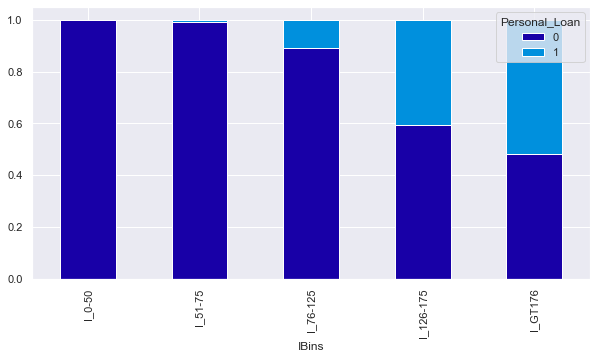

In [66]:
stacked_plot(ldf3["IBins"])

#### Observations
- More than Half of those with Income above 175k accepted an offer for the personal loan
- Nearly half of those with income between 126 and 175 accepted an offer for the personal loan
- Only 7 accepted the offer for incomes up to 75k
- Individuals with higher incomes seem to be more likely to accept the offer overall


#### Education

Personal_Loan     0    1   All
Education                     
1              2003   93  2096
2              1221  182  1403
3              1296  205  1501
All            4520  480  5000
------------------------------------------------------------------------------------------------------------------------


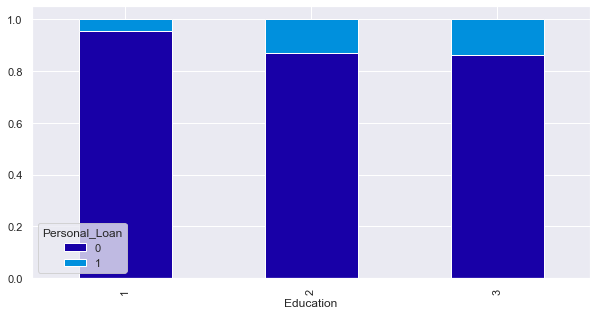

In [67]:
stacked_plot(ldf3["Education"])

#### Observations
- Graduate and Advanced / Professional (2,3) have a roughly 15% acceptance rate of the loan
- Only 4% of undergraduates (1) accepted the offer

#### Family

Personal_Loan     0    1   All
Family                        
1              1365  107  1472
2              1190  106  1296
3               877  133  1010
4              1088  134  1222
All            4520  480  5000
------------------------------------------------------------------------------------------------------------------------


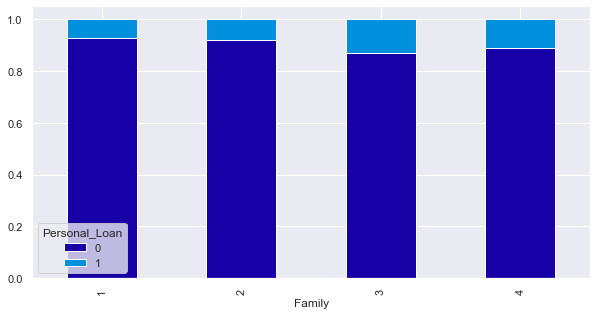

In [68]:
stacked_plot(ldf3["Family"])

#### Observations
- Family size has only a small impact on loan acceptance with 3 having slightly higher acceptance rate at 15%.  This is a bit surprising given 3 accounts for the smallest portion of the sample

#### Experience

Personal_Loan     0    1   All
ExpBin                        
Low            1156  133  1289
Medium         1135  118  1253
High           1182  119  1301
Very High      1047  110  1157
All            4520  480  5000
------------------------------------------------------------------------------------------------------------------------


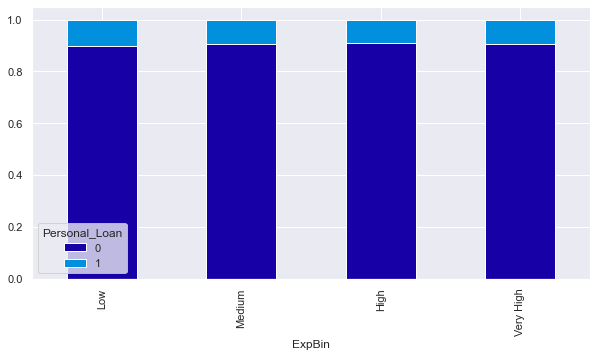

In [69]:
stacked_plot(ldf3["ExpBin"])

#### Observations
Experience seems to have little impact on acceptance of loan, each level of experience is ~11%

#### Mortgage

Personal_Loan     0    1   All
MBins                         
M_None         3150  312  3462
M_0-75            7    1     8
M_76-100        262   12   274
M_101-200       719   39   758
M_GT200         382  116   498
All            4520  480  5000
------------------------------------------------------------------------------------------------------------------------


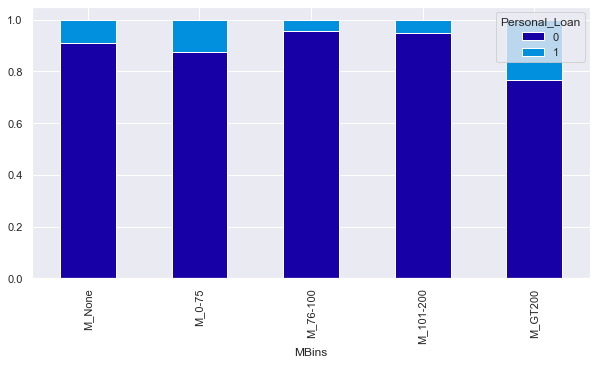

In [70]:
stacked_plot(ldf3["MBins"])

#### Observations
- Customers with mortgages higher then 200k were more likely to accept the loan with 30%
- There are only 8 customers with mortgages below 75k and only 1 accepted the offer.
- Mortgages between 76k and 200k are around 5% acceptance
- Interestingly those with no mortgage have a higher acceptance rate than the 76k to 200k range


#### Age

Personal_Loan     0    1   All
Age                           
23               12    0    12
24               28    0    28
25               53    0    53
26               65   13    78
27               79   12    91
28               94    9   103
29              108   15   123
30              119   17   136
31              118    7   125
32              108   12   120
33              105   15   120
34              116   18   134
35              135   16   151
36               91   16   107
37               98    8   106
38              103   12   115
39              127    6   133
40              117    8   125
41              128    8   136
42              112   14   126
43              134   15   149
44              107   14   121
45              114   13   127
46              114   13   127
47              103   10   113
48              106   12   118
49              105   10   115
50              125   13   138
51              119   10   129
52              130   15   145
53      

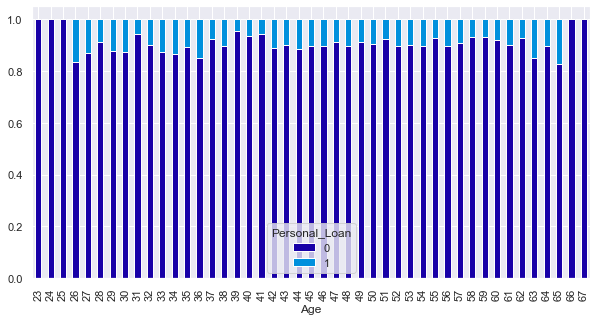

In [71]:
stacked_plot(ldf3["Age"])

#### Observations
- There are customers from every age who accepted a loan except for the extremes - 23, 24 & 66,67
- All other ages average around 12% for loan acceptance
- Given this fact we may bin ages to reduce complexity and reduce scale


#### Convert age to categorical
- 0-20 - A_0-20
- 20-30 - A_20-30
- 31-40 - A_31-40
- 41-50 - A_41-50
- 51-60 = A_51-60
- 60+ = A_GT60

In [72]:
# Bin Age
cut_labels5 = ['A_0-20', 'A_20-30', 'A_31-40', 'A_41-50', 'A_51-60', 'A_GT60']
cut_bins5 = [0, 20, 30, 40, 50, 60, np.inf]
ldf3['AgeBins'] = pd.cut(ldf2['Age'], bins=cut_bins5, labels=cut_labels5)

In [73]:
ldf3[['Age', 'AgeBins']].sample(10)

,Age,AgeBins
ID,,
4749,43,A_41-50
2433,54,A_51-60
4456,56,A_51-60
4266,27,A_20-30
1319,52,A_51-60
505,40,A_31-40
965,27,A_20-30
4014,62,A_GT60
138,49,A_41-50


Personal_Loan     0    1   All
AgeBins                       
A_20-30         558   66   624
A_31-40        1118  118  1236
A_41-50        1148  122  1270
A_51-60        1208  115  1323
A_GT60          488   59   547
All            4520  480  5000
------------------------------------------------------------------------------------------------------------------------


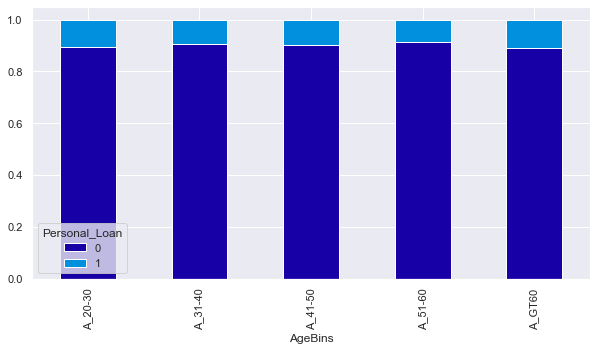

In [74]:
stacked_plot(ldf3["AgeBins"])

#### Observations
- Customers in the 20-30 and 51-60 bins account for only 2.5% of the customer base but still have about the same loan acceptance rate of ~10%

#### Securities_Account

Personal_Loan          0    1   All
Securities_Account                 
0                   4058  420  4478
1                    462   60   522
All                 4520  480  5000
------------------------------------------------------------------------------------------------------------------------


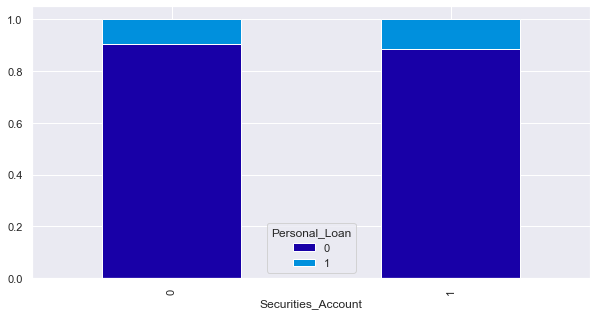

In [75]:
stacked_plot(ldf3["Securities_Account"])

#### Observations
- Those who do not have securities (10%) and those who do (12%) were roughly equally likely to accept a personal loan

#### CD_Account

Personal_Loan     0    1   All
CD_Account                    
0              4358  340  4698
1               162  140   302
All            4520  480  5000
------------------------------------------------------------------------------------------------------------------------


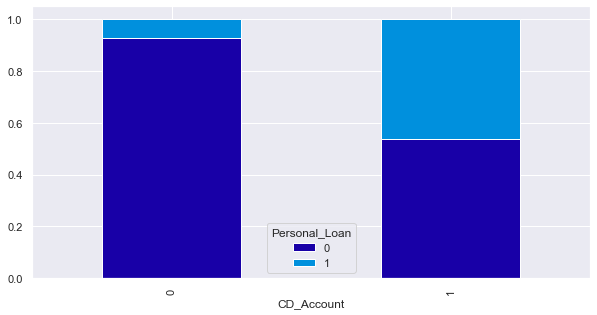

In [76]:
stacked_plot(ldf3["CD_Account"])

#### observations
- Only ~6% of customers have a CD_Account, of those who do nearly half (46%) have accepted a personal loan.
- This could be an important indicator, we should explore CD_account further

#### Online

Personal_Loan     0    1   All
Online                        
0              1827  189  2016
1              2693  291  2984
All            4520  480  5000
------------------------------------------------------------------------------------------------------------------------


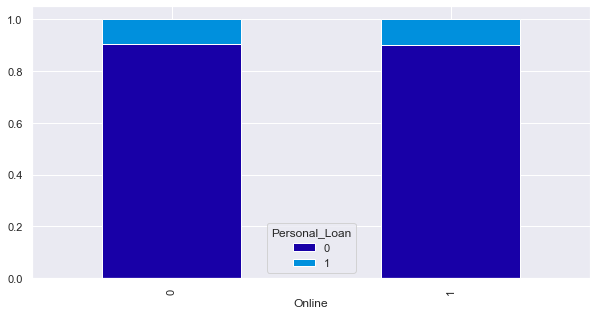

In [77]:
stacked_plot(ldf3["Online"])

#### Observations
- Customers who bank online and those who do not bank online both have ~9% loan acceptance

#### CreditCard

Personal_Loan     0    1   All
CreditCard                    
0              3193  337  3530
1              1327  143  1470
All            4520  480  5000
------------------------------------------------------------------------------------------------------------------------


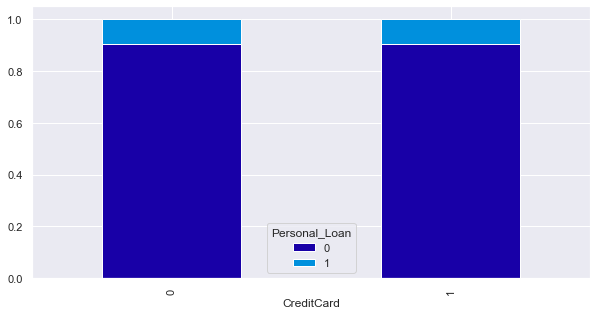

In [78]:
stacked_plot(ldf3["CreditCard"])

#### Observations
- Similar to online, of those who have and do not have credit cards outside AllLife Bank only ~ 9% accepted personal loan

#### County (ZIPCode)

Personal_Loan             0    1   All
County                                
Alameda County          456   44   500
Contra Costa County      73   12    85
County_Other            314   32   346
Kern County              47    7    54
Los Angeles County      984  111  1095
Marin County             48    6    54
Monterey County         113   15   128
Orange County           309   30   339
Riverside County         50    6    56
Sacramento County       169   15   184
San Bernardino County    98    3   101
San Diego County        509   59   568
San Francisco County    238   19   257
San Mateo County        192   12   204
Santa Barbara County    143   11   154
Santa Clara County      492   71   563
Santa Cruz County        60    8    68
Ventura County          103   11   114
Yolo County             122    8   130
All                    4520  480  5000
------------------------------------------------------------------------------------------------------------------------


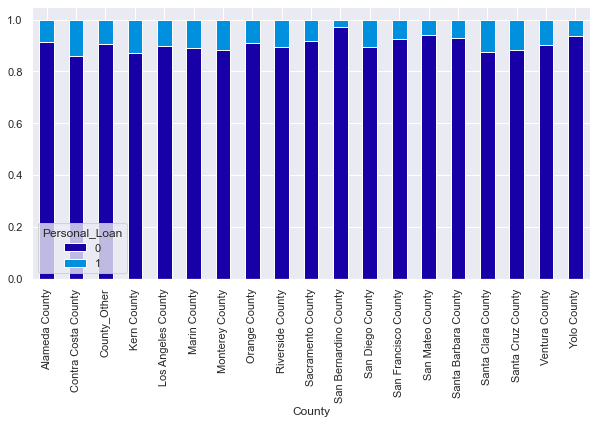

In [79]:
stacked_plot(ldf3["County"])

#### Observations 
- LA County has by bar the largest # of AllLife Bank customers followed by San Diego County and Santa Clara County
- LA County had a 10% acceptance
- San Diego County had a 10% acceptance
- Santa Clara county has the highest acceptance rate 13% but has about half the customers of LA County

#### CCAverage (CCABin)

Personal_Loan     0    1   All
CCABin                        
CCA_None        105    1   106
CCA_Low        1760   48  1808
CCA_Medium     1286   47  1333
CCA_High       1040  163  1203
CCA_VeryHigh    329  221   550
All            4520  480  5000
------------------------------------------------------------------------------------------------------------------------


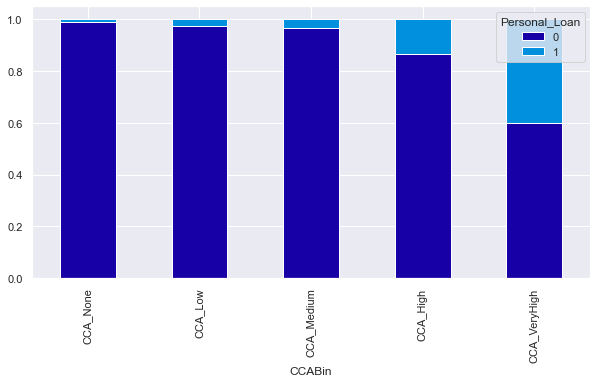

In [80]:
stacked_plot(ldf3["CCABin"])

#### Observations
- The higher the monthly average for credit cards the more likely someone was to accept a personal loan
- Those with No CC Average account for < 1% of loan acceptance - within their category
- Those with Very High CC Average account for 40% of loan acceptance - within their category
- CC Average could be a good indicator of who would accept a new personal loan


<AxesSubplot:xlabel='CCAvg', ylabel='Age'>

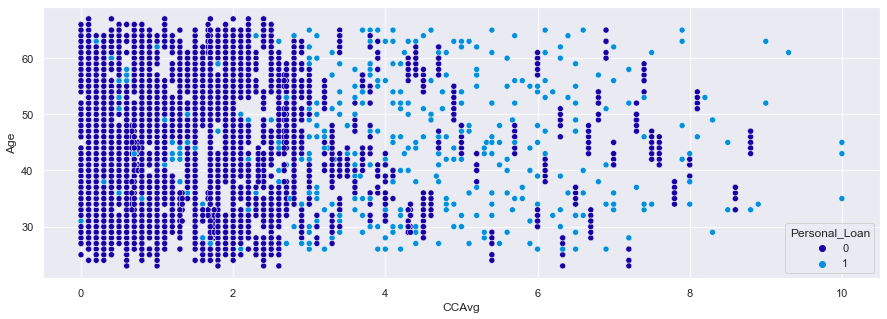

In [81]:
# Age vs CCAverage with Personal_Loan hue
plt.figure(figsize=(15,5))
sns.scatterplot(x='CCAvg', y='Age', hue='Personal_Loan', data=ldf3)

### Observations
- Although there are far fewer customers with CC average > 3.5k they account for the majority of accepted loans
- Age seems to have little impact on CCAverage or Personal_Loan

<AxesSubplot:xlabel='Income', ylabel='CCAvg'>

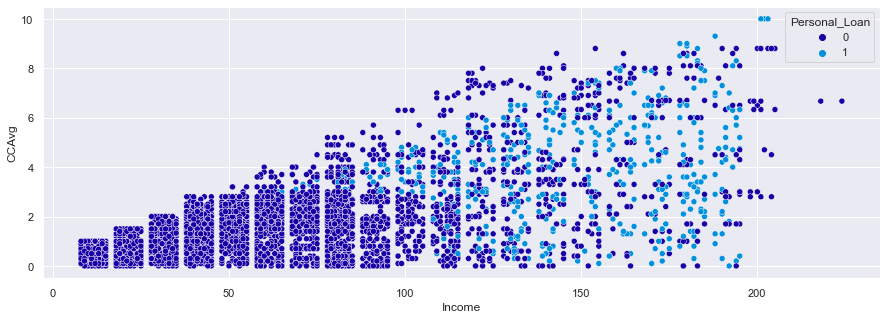

In [82]:
# Income vs CCAverage with Personal_Loan hue
plt.figure(figsize=(15,5))
sns.scatterplot(x='Income', y='CCAvg', hue='Personal_Loan', data=ldf3)

#### Observations
- As seen earlier in the heatmap, Income and CCAverage are fairly correlated 
- The majority of personal loans are to incomes above 100k


<AxesSubplot:xlabel='Income', ylabel='County'>

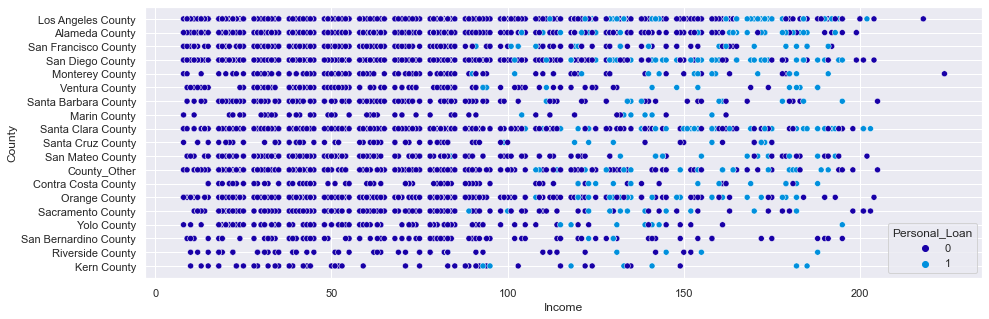

In [83]:
# Income vs County with Personal_Loan hue
plt.figure(figsize=(15,5))
sns.scatterplot(x='Income', y='County', hue='Personal_Loan', data=ldf3)

#### Observations
- Personal loans look to be fairly evenly distributed across counties
- Personal loans are distributed primarily above 100k regardless of the county


<AxesSubplot:xlabel='Experience', ylabel='Income'>

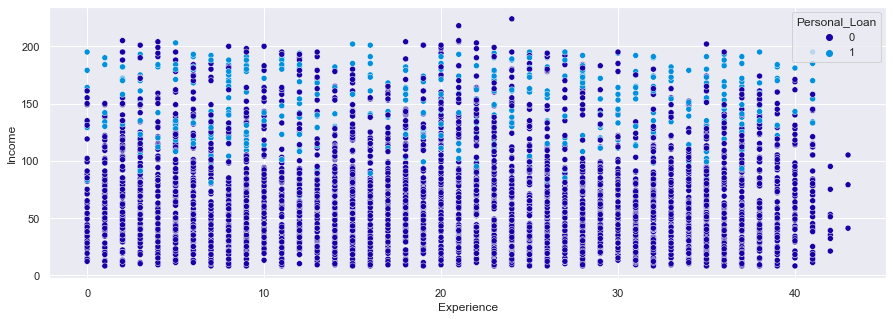

In [84]:
# Experience vs Income with Personal_Loan hue
plt.figure(figsize=(15,5))
sns.scatterplot(x='Experience', y='Income',hue='Personal_Loan' , data=ldf3)

#### Observations
- No one with an income below 75k accepted a personal loan
- Experience and Income seem to have little to no correlation
- Personal Loan appears to be evenly distributed across experience

<AxesSubplot:xlabel='Experience', ylabel='Age'>

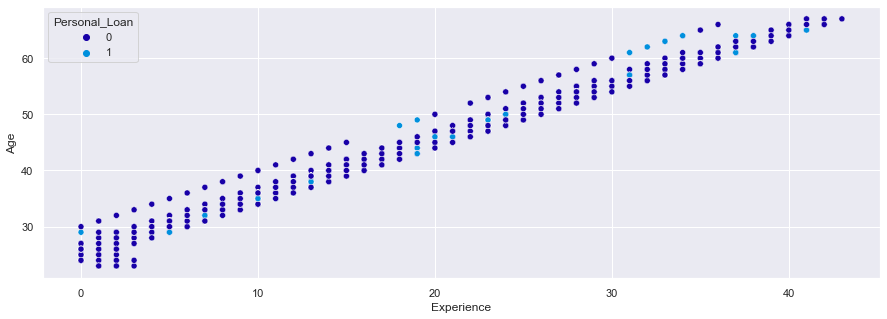

In [85]:
# Age vs Experience with Personal_Loan hue
plt.figure(figsize=(15,5))
sns.scatterplot(x='Experience', y='Age',hue='Personal_Loan' , data=ldf3)

#### Observations

- As would be expected age and experience are highly correlated

# EDA Takeaways & Recommendations

#### Generally, customers who use more of the banks services and have have higher  averages for those services were more likely to have accepted a personal loan.  This makes some sense as most of these customers have higher debt with AllLife Bank and may be more willing to extend that debt further.  These same customers also tend to have higher incomes.  Age, Education, Experience & Family size do not seem to have much impact on personal loan acceptance.


#### Key Ovservations
- More than Half of those with Income above 175k accepted an offer for the personal loan
- The majority of personal loans are to incomes above 100k
- Nearly half of those with income between 126 and 175 accepted an offer for the personal loan
- Customers with mortgages higher then 200k show a  30% acceptance rate
- Mortgages between 76k and 200k are around 5% acceptance
- Only ~6% of customers have a CD_Account, of those who do nearly half (46%) have accepted a personal loan.
- The higher the monthly average for credit cards the more likely someone was to accept a personal loan with the majority of loan acceptance having an average above 3.5
- 40% of customers with Very High CCAvg accepted personal loans
- No one with an income below 75k accepted a personal loan
- All CCAvg >= 8k have incomes higher the 143k
- Most Customers 36.2% have a low monthly CCAvg
- Santa Clara county has the highest acceptance rate 13% but has about half the customers of LA County
 - 69% of customers do not have a mortgage

#### Recommendations for next campaign
- Target incomes above 100k
- Target CCAvg > 3.5k
- Target customers with CD_Accounts
- Target Mortgages above 200K
- Examine customers in Santa Clara County more closely and possibly market heavier to them.
- Marketing other services, such as CD_Accoutns, could increase willingness to accept a personal loan


### Prepare data for Split and model building
#### Keep seperate data sets one with continuous variables kept and with continuous variables binned & build initial models with each to see results.

Current dataframe is ldf3
- Split ldf3 into:
-- ldf_continuous
-- ldf_binned

In [86]:
cols = ldf3.columns
cols

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'Personal_Loan', 'Securities_Account', 'CD_Account',
       'Online', 'CreditCard', 'County', 'ExpBin', 'IBins', 'CCABin', 'MBins',
       'AgeBins'],
      dtype='object')

In [87]:
# Create copies of dataframe
ldf_continuous = ldf3.copy()
ldf_binned = ldf3.copy()

In [88]:
# remove  'ExpBin', 'CCABin', 'MBins', 'IBins', 'AgeBins'
ldf_continuous_drop =['ExpBin', 'CCABin', 'MBins', 'IBins', 'AgeBins']

In [89]:
ldf_continuous.drop(ldf_continuous_drop,axis=1,inplace=True)

In [90]:
ldf_continuous.head(2)

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,County
ID,,,,,,,,,,,,,
1,25,1,49,4,1.6,1,0,0,1,0,0,0,Los Angeles County
2,45,19,34,3,1.5,1,0,0,1,0,0,0,Los Angeles County


In [91]:
# remove Age, Experience, Income, Mortgage, CCAvg
ldf_binned_drop = ['Age', 'Experience', 'Income', 'Mortgage', 'CCAvg']

In [92]:
ldf_binned.drop(ldf_binned_drop,axis=1,inplace=True)

In [93]:
ldf_binned.head(2)

,Family,Education,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,County,ExpBin,IBins,CCABin,MBins,AgeBins
ID,,,,,,,,,,,,,
1,4,1,0,1,0,0,0,Los Angeles County,Low,I_0-50,CCA_Medium,M_None,A_20-30
2,3,1,0,1,0,0,0,Los Angeles County,Medium,I_0-50,CCA_Medium,M_None,A_41-50


In [94]:
#Check types for new dataframes
print('ldf continuous', ldf_continuous.info())
print('ldf binned', ldf_binned.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Experience          5000 non-null   int64   
 2   Income              5000 non-null   int64   
 3   Family              5000 non-null   category
 4   CCAvg               5000 non-null   float64 
 5   Education           5000 non-null   category
 6   Mortgage            5000 non-null   int64   
 7   Personal_Loan       5000 non-null   category
 8   Securities_Account  5000 non-null   category
 9   CD_Account          5000 non-null   category
 10  Online              5000 non-null   category
 11  CreditCard          5000 non-null   category
 12  County              5000 non-null   object  
dtypes: category(7), float64(1), int64(4), object(1)
memory usage: 468.4+ KB
ldf continuous None
<class 'pandas.core.frame.DataFrame'>
Int64Ind

In [95]:
# convert County from object to category
ldf_continuous.County = ldf_continuous.County.astype('category')
ldf_binned.County = ldf_binned.County.astype('category')

In [96]:
print('ldf continuous', ldf_continuous.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Experience          5000 non-null   int64   
 2   Income              5000 non-null   int64   
 3   Family              5000 non-null   category
 4   CCAvg               5000 non-null   float64 
 5   Education           5000 non-null   category
 6   Mortgage            5000 non-null   int64   
 7   Personal_Loan       5000 non-null   category
 8   Securities_Account  5000 non-null   category
 9   CD_Account          5000 non-null   category
 10  Online              5000 non-null   category
 11  CreditCard          5000 non-null   category
 12  County              5000 non-null   category
dtypes: category(8), float64(1), int64(4)
memory usage: 435.0 KB
ldf continuous None


#### Look at loan ratio in the dependent variable

In [97]:
n_true = len(ldf_continuous.loc[ldf_continuous['Personal_Loan'] == 1])
n_false = len(ldf_continuous.loc[ldf_continuous['Personal_Loan'] == 0])
print("Number of true cases: {0} ({1:2.2f}%)".format(n_true, (n_true / (n_true + n_false)) * 100 ))
print("Number of false cases: {0} ({1:2.2f}%)".format(n_false, (n_false / (n_true + n_false)) * 100))

Number of true cases: 480 (9.60%)
Number of false cases: 4520 (90.40%)


#### The data contains only 9.6% of people who accepted the loan during the previous campaign, thus we have an imbalanced dataset
#### We will want to try the model and see how well it performs with the test data.  If necessary we will oversample the training data and check results.

If oversampling is necessary we will use the SMOTE algorithm(Synthetic Minority Oversampling Technique) to oversample the training set.

At a high level, SMOTE:
- Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
- Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

## ----------------------ldf_continuous ---------------------------------------------
##   Split, encode, build Logistic Regression Model 
## -----------------------------------------------------------------------------------------

Xlrc & ylrc will be variables for this model lrc=logistic regression continuous

In [98]:
# Test train split - 70:30
Xlrc = ldf_continuous.drop('Personal_Loan',axis=1) # Predictor Features (12)
ylrc = ldf_continuous['Personal_Loan']   # Predicted class (1=Accepted, 0=Did not accept) 

Xlrc_train, Xlrc_test, ylrc_train, ylrc_test = train_test_split(Xlrc, ylrc, test_size=0.3, random_state=2021)

display(Xlrc_train.head())
display(ylrc_train.head())

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities_Account,CD_Account,Online,CreditCard,County
ID,,,,,,,,,,,,
2637,38,13,179,1,4.1,1,0,0,0,1,0,Monterey County
1466,45,19,60,1,0.7,3,159,0,0,1,0,San Diego County
1547,33,9,105,1,4.0,1,0,0,0,1,0,Santa Clara County
4207,48,23,29,1,1.3,2,0,0,0,0,0,County_Other
4376,34,10,51,3,2.0,1,130,0,0,0,0,Los Angeles County


ID
2637    0
1466    0
1547    0
4207    0
4376    0
Name: Personal_Loan, dtype: category
Categories (2, int64): [0, 1]

In [99]:
# Check loan / no loan ratio across the sets
print("Original Loan True Values    : {0} ({1:0.2f}%)".format(len(ldf_continuous.loc[ldf_continuous['Personal_Loan'] == 1]), (len(ldf_continuous.loc[ldf_continuous['Personal_Loan'] == 1])/len(ldf_continuous.index)) * 100))
print("Original Loan False Values   : {0} ({1:0.2f}%)".format(len(ldf_continuous.loc[ldf_continuous['Personal_Loan'] == 0]), (len(ldf_continuous.loc[ldf_continuous['Personal_Loan'] == 0])/len(ldf_continuous.index)) * 100))
print("")
print("Training Loan True Values    : {0} ({1:0.2f}%)".format(len(ylrc_train[ylrc_train[:] == 1]), (len(ylrc_train[ylrc_train[:] == 1])/len(ylrc_train)) * 100))
print("Training Loan False Values   : {0} ({1:0.2f}%)".format(len(ylrc_train[ylrc_train[:] == 0]), (len(ylrc_train[ylrc_train[:] == 0])/len(ylrc_train)) * 100))
print("")
print("Test Loan True Values        : {0} ({1:0.2f}%)".format(len(ylrc_test[ylrc_test[:] == 1]), (len(ylrc_test[ylrc_test[:] == 1])/len(ylrc_test)) * 100))
print("Test Loan False Values       : {0} ({1:0.2f}%)".format(len(ylrc_test[ylrc_test[:] == 0]), (len(ylrc_test[ylrc_test[:] == 0])/len(ylrc_test)) * 100))
print("")

Original Loan True Values    : 480 (9.60%)
Original Loan False Values   : 4520 (90.40%)

Training Loan True Values    : 326 (9.31%)
Training Loan False Values   : 3174 (90.69%)

Test Loan True Values        : 154 (10.27%)
Test Loan False Values       : 1346 (89.73%)



The ratio of loan / no loan across the original, train & test sets are roughly the same, no additional work needed at this point.

#### One Hot Encode County 

In [100]:
# create dummy variable for train set
print('Before OHE:', Xlrc_train.shape)
Xlrc_train = pd.get_dummies(Xlrc_train, columns=['County'], drop_first=True)
print('After OHE:', Xlrc_train.shape)
display(Xlrc_train.head(2))

# create dummy variable for test set
print('Before OHE:', Xlrc_test.shape)
Xlrc_test = pd.get_dummies(Xlrc_test, columns=['County'], drop_first=True)
print('After OHE:', Xlrc_test.shape)
display(Xlrc_test.head(2))

Before OHE: (3500, 12)
After OHE: (3500, 29)


,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities_Account,CD_Account,Online,CreditCard,County_Contra Costa County,County_County_Other,County_Kern County,County_Los Angeles County,County_Marin County,County_Monterey County,County_Orange County,County_Riverside County,County_Sacramento County,County_San Bernardino County,County_San Diego County,County_San Francisco County,County_San Mateo County,County_Santa Barbara County,County_Santa Clara County,County_Santa Cruz County,County_Ventura County,County_Yolo County
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2637,38,13,179,1,4.1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1466,45,19,60,1,0.7,3,159,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


Before OHE: (1500, 12)
After OHE: (1500, 29)


,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities_Account,CD_Account,Online,CreditCard,County_Contra Costa County,County_County_Other,County_Kern County,County_Los Angeles County,County_Marin County,County_Monterey County,County_Orange County,County_Riverside County,County_Sacramento County,County_San Bernardino County,County_San Diego County,County_San Francisco County,County_San Mateo County,County_Santa Barbara County,County_Santa Clara County,County_Santa Cruz County,County_Ventura County,County_Yolo County
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1250,51,27,80,1,2.6,2,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1471,58,28,80,2,4.5,3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


One hot encoding county increased the number of features by 17

### Model evaluation 

### We will be using F1_Score as the primary metric for this model, because we want to reduce losses of both: 
1. Offer a loan to someone who either rejects or is not accepted for the loan - Loss of money
2. Not offer to those who may have accepted the offer and been accepted for the loan - Loss of opportunity

- Marketing to / offering a loan to someone who does not accept or could be turned down for the loan.  Cost of marketing and processing customers for a loan that they may not qualify for.  Also, potential very bad perception from existing customers.
- Missing existing customers who may accept & qualify for the personal loan

In [101]:
# Function to return metrics on StatsModel models
def get_metrics_statsmodel(model,train,test,train_y,test_y,threshold=0.5,flag=True,roc=False):
    '''
    Function to calculate different metric scores of the model - Accuracy, Recall, Precision, and F1 score
    model: classifier to predict values of X
    train, test: Independent features
    train_y,test_y: Dependent variable
    threshold: thresold for classifiying the observation as 1
    flag: If the flag is set to True then only the print statements showing different will be displayed. The default value is set to True.
    roc: If the roc is set to True then only roc score will be displayed. The default value is set to False.
    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    pred_train = (model.predict(train)>threshold)
    pred_test = (model.predict(test)>threshold)

    pred_train = np.round(pred_train)
    pred_test = np.round(pred_test)
    
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)
    
    train_recall = recall_score(train_y,pred_train)
    test_recall = recall_score(test_y,pred_test)
    
    train_precision = precision_score(train_y,pred_train)
    test_precision = precision_score(test_y,pred_test)
    
    train_f1 = f1_score(train_y,pred_train)
    test_f1 = f1_score(test_y,pred_test)
    
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1))
        
    
    if flag == True: 
        print("Accuracy on training set : ",accuracy_score(pred_train,train_y))
        print("Accuracy on test set : ",accuracy_score(pred_test,test_y))
        print("Recall on training set : ",recall_score(train_y,pred_train))
        print("Recall on test set : ",recall_score(test_y,pred_test))
        print("Precision on training set : ",precision_score(train_y,pred_train))
        print("Precision on test set : ",precision_score(test_y,pred_test))
        print("F1 on training set : ",f1_score(train_y,pred_train))
        print("F1 on test set : ",f1_score(test_y,pred_test))
   
    if roc == True:
        print("ROC-AUC Score on training set : ",roc_auc_score(train_y,pred_train))
        print("ROC-AUC Score on test set : ",roc_auc_score(test_y,pred_test))
    
    return score_list # returning the list with train and test scores

In [102]:
# Function to return metrics on SKLearn models
def get_metrics_sklearn(model,train,test,train_y,test_y,flag=True,roc=False):
    '''
    Function to calculate different metric scores of the model - Accuracy, Recall, Precision, and F1 score
    model: classifier to predict values of X
    train, test: Independent features
    train_y,test_y: Dependent variable
    flag: If the flag is set to True then only the print statements shwoing different will be displayed. The default value is set to True.
    roc: If the roc is set to True then only roc score will be displayed. The default value is set to False.
    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)
    
    train_recall = recall_score(train_y,pred_train)
    test_recall = recall_score(test_y,pred_test)
    
    train_precision = precision_score(train_y,pred_train)
    test_precision = precision_score(test_y,pred_test)
    
    train_f1 = f1_score(train_y,pred_train)
    test_f1 = f1_score(test_y,pred_test)
    
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1))
        
     # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",accuracy_score(pred_train,train_y))
        print("Accuracy on test set : ",accuracy_score(pred_test,test_y))
        print("Recall on training set : ",recall_score(train_y,pred_train))
        print("Recall on test set : ",recall_score(test_y,pred_test))
        print("Precision on training set : ",precision_score(train_y,pred_train))
        print("Precision on test set : ",precision_score(test_y,pred_test))
        print("F1 on training set : ",f1_score(train_y,pred_train))
        print("F1 on test set : ",f1_score(test_y,pred_test))
        
    if roc == True:
        print("ROC-AUC Score on training set : ",roc_auc_score(train_y,pred_train))
        print("ROC-AUC Score on test set : ",roc_auc_score(test_y,pred_test))
    
    return score_list # returning the list with train and test scores

In [103]:
# Function to make confusion matrix
def make_confusion_matrix(y_actual,y_predict,labels=[1, 0]):
    '''
    y_predict: prediction of class
    y_actual : ground truth  
    '''
    cm=confusion_matrix( y_predict,y_actual, labels=[1, 0])
    df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ['1','0']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (7,5))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Build the initial model with sklearn - solver = newton-cg

In [104]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [105]:
# Add constant for sklearn 
Xlrc_train = sm.add_constant(Xlrc_train)
Xlrc_test = sm.add_constant(Xlrc_test)

In [106]:
# Build Logistic Regression Model
lrcn = LogisticRegression(solver='newton-cg',random_state=1,fit_intercept=False)
model_lrcn  = lrcn.fit(Xlrc_train,ylrc_train)

# Let's check model performances for this model
scores_LR = get_metrics_sklearn(model_lrcn,Xlrc_train,Xlrc_test,ylrc_train,ylrc_test)

Accuracy on training set :  0.9502857142857143
Accuracy on test set :  0.9506666666666667
Recall on training set :  0.5950920245398773
Recall on test set :  0.6298701298701299
Precision on training set :  0.8220338983050848
Precision on test set :  0.8508771929824561
F1 on training set :  0.690391459074733
F1 on test set :  0.7238805970149255


#### Initial F1 results with sklern - solver = newton-cg using ldf_continuous dataset are not as high as we would like.
#### Before proceeding to identify significant features we will try using a different solver as well as the dataframe ldf_binned

### Build logistic regression on ldf_continuous - solver = liblinear

In [107]:
lrcl = LogisticRegression(solver="liblinear")
model_lrcl  = lrcl.fit(Xlrc_train,ylrc_train)

# Let's check model performances for this model
scores_LR = get_metrics_sklearn(model_lrcl,Xlrc_train,Xlrc_test,ylrc_train,ylrc_test)

Accuracy on training set :  0.9505714285714286
Accuracy on test set :  0.9513333333333334
Recall on training set :  0.5950920245398773
Recall on test set :  0.6298701298701299
Precision on training set :  0.825531914893617
Precision on test set :  0.8584070796460177
F1 on training set :  0.6916221033868093
F1 on test set :  0.7265917602996255


#### Results for both solver types are nearly identical with liblinear being very slightly better on F1 score
#### Try sklearn with the ldf_binned DataFrame

## ----------------------ldf_binned ---------------------------------------------------
##   Encode, split & build Logistic Regression Model 
## -----------------------------------------------------------------------------------------

Xlrb & ylrb will be the variables for this model -- lrb=logistic regression binned

Data preparation on this set will also be used for Decision Tree Model building

#### Data preparation for ldf_binned prior to splitting for train & test sets
- one hot encode - County
- label encode ordinals - ExpBin, IBins, CCABin, MBins, AgeBins

In [108]:
# create dummy variable for County
print('Before OHE:', ldf_binned.shape)
ldf_binned = pd.get_dummies(ldf_binned, columns=['County'], drop_first=True)
print('After OHE:', ldf_binned.shape)
display(ldf_binned.head(2))

Before OHE: (5000, 13)
After OHE: (5000, 30)


,Family,Education,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,ExpBin,IBins,CCABin,MBins,AgeBins,County_Contra Costa County,County_County_Other,County_Kern County,County_Los Angeles County,County_Marin County,County_Monterey County,County_Orange County,County_Riverside County,County_Sacramento County,County_San Bernardino County,County_San Diego County,County_San Francisco County,County_San Mateo County,County_Santa Barbara County,County_Santa Clara County,County_Santa Cruz County,County_Ventura County,County_Yolo County
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4,1,0,1,0,0,0,Low,I_0-50,CCA_Medium,M_None,A_20-30,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,0,1,0,0,0,Medium,I_0-50,CCA_Medium,M_None,A_41-50,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### OHE on county increased the feature size by 17

#### Label encode 5 ordinal features


In [109]:
labelsEB = ldf_binned['ExpBin'].astype('category').cat.categories.tolist()
replace_map_compEB = {'ExpBin' : {k: v for k,v in zip(labelsEB,list(range(1,len(labelsEB)+1)))}}
print(replace_map_compEB)

{'ExpBin': {'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}}


In [110]:
labelsIB = ldf_binned['IBins'].astype('category').cat.categories.tolist()
replace_map_compIB = {'IBins' : {k: v for k,v in zip(labelsIB,list(range(1,len(labelsIB)+1)))}}
print(replace_map_compIB)

{'IBins': {'I_0-50': 1, 'I_51-75': 2, 'I_76-125': 3, 'I_126-175': 4, 'I_GT176': 5}}


In [111]:
labelsCB = ldf_binned['CCABin'].astype('category').cat.categories.tolist()
replace_map_compCB = {'CCABin' : {k: v for k,v in zip(labelsCB,list(range(1,len(labelsCB)+1)))}}
print(replace_map_compCB)

{'CCABin': {'CCA_None': 1, 'CCA_Low': 2, 'CCA_Medium': 3, 'CCA_High': 4, 'CCA_VeryHigh': 5}}


In [112]:
labelsMB = ldf_binned['MBins'].astype('category').cat.categories.tolist()
replace_map_compMB = {'MBins' : {k: v for k,v in zip(labelsMB,list(range(1,len(labelsMB)+1)))}}
print(replace_map_compMB)

{'MBins': {'M_None': 1, 'M_0-75': 2, 'M_76-100': 3, 'M_101-200': 4, 'M_GT200': 5}}


In [113]:
labelsAB = ldf_binned['AgeBins'].astype('category').cat.categories.tolist()
replace_map_compAB = {'AgeBins' : {k: v for k,v in zip(labelsAB,list(range(1,len(labelsAB)+1)))}}
print(replace_map_compAB)

{'AgeBins': {'A_0-20': 1, 'A_20-30': 2, 'A_31-40': 3, 'A_41-50': 4, 'A_51-60': 5, 'A_GT60': 6}}


In [114]:
ldf_binnedEnc = ldf_binned.copy()
ldf_binnedEnc.head(2)

,Family,Education,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,ExpBin,IBins,CCABin,MBins,AgeBins,County_Contra Costa County,County_County_Other,County_Kern County,County_Los Angeles County,County_Marin County,County_Monterey County,County_Orange County,County_Riverside County,County_Sacramento County,County_San Bernardino County,County_San Diego County,County_San Francisco County,County_San Mateo County,County_Santa Barbara County,County_Santa Clara County,County_Santa Cruz County,County_Ventura County,County_Yolo County
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4,1,0,1,0,0,0,Low,I_0-50,CCA_Medium,M_None,A_20-30,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,0,1,0,0,0,Medium,I_0-50,CCA_Medium,M_None,A_41-50,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [115]:
# Replace binned lables with numeric values 
ldf_binnedEnc.replace(replace_map_compEB, inplace=True)
ldf_binnedEnc.replace(replace_map_compIB, inplace=True)
ldf_binnedEnc.replace(replace_map_compCB, inplace=True)
ldf_binnedEnc.replace(replace_map_compMB, inplace=True)
ldf_binnedEnc.replace(replace_map_compAB, inplace=True)
ldf_binnedEnc.head(2)

,Family,Education,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,ExpBin,IBins,CCABin,MBins,AgeBins,County_Contra Costa County,County_County_Other,County_Kern County,County_Los Angeles County,County_Marin County,County_Monterey County,County_Orange County,County_Riverside County,County_Sacramento County,County_San Bernardino County,County_San Diego County,County_San Francisco County,County_San Mateo County,County_Santa Barbara County,County_Santa Clara County,County_Santa Cruz County,County_Ventura County,County_Yolo County
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4,1,0,1,0,0,0,1,1,3,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,0,1,0,0,0,2,1,3,1,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [116]:
ldf_binnedEnc.shape

(5000, 30)

#### All features in ldf_binned have been encoded. 

In [117]:
# Test train split - 70:30
Xlrb = ldf_binnedEnc.drop('Personal_Loan',axis=1) 
ylrb = ldf_binnedEnc['Personal_Loan']   # Predicted class (1=Accepted, 0=Did not accept) 

Xlrb_train, Xlrb_test, ylrb_train, ylrb_test = train_test_split(Xlrb, ylrb, test_size=0.3, random_state=2021)

display(Xlrb_train.head())
display(ylrb_train.sample(10))

,Family,Education,Securities_Account,CD_Account,Online,CreditCard,ExpBin,IBins,CCABin,MBins,AgeBins,County_Contra Costa County,County_County_Other,County_Kern County,County_Los Angeles County,County_Marin County,County_Monterey County,County_Orange County,County_Riverside County,County_Sacramento County,County_San Bernardino County,County_San Diego County,County_San Francisco County,County_San Mateo County,County_Santa Barbara County,County_Santa Clara County,County_Santa Cruz County,County_Ventura County,County_Yolo County
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2637,1,1,0,0,1,0,2,5,5,1,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1466,1,3,0,0,1,0,2,2,2,4,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1547,1,1,0,0,1,0,1,3,4,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4207,1,2,0,0,0,0,3,1,3,1,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4376,3,1,0,0,0,0,1,2,3,4,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


ID
1257    0
2527    0
11      0
390     0
4115    0
1286    1
3470    0
3628    0
3893    0
3000    0
Name: Personal_Loan, dtype: category
Categories (2, int64): [0, 1]

In [118]:
# Check loan / no loan ratio across the sets
print("Original Loan True Values    : {0} ({1:0.2f}%)".format(len(ldf_binnedEnc.loc[ldf_binnedEnc['Personal_Loan'] == 1]), (len(ldf_binnedEnc.loc[ldf_binnedEnc['Personal_Loan'] == 1])/len(ldf_binnedEnc.index)) * 100))
print("Original Loan False Values   : {0} ({1:0.2f}%)".format(len(ldf_binnedEnc.loc[ldf_binnedEnc['Personal_Loan'] == 0]), (len(ldf_binnedEnc.loc[ldf_binnedEnc['Personal_Loan'] == 0])/len(ldf_binnedEnc.index)) * 100))
print("")
print("Training Loan True Values    : {0} ({1:0.2f}%)".format(len(ylrb_train[ylrb_train[:] == 1]), (len(ylrb_train[ylrb_train[:] == 1])/len(ylrb_train)) * 100))
print("Training Loan False Values   : {0} ({1:0.2f}%)".format(len(ylrb_train[ylrb_train[:] == 0]), (len(ylrb_train[ylrb_train[:] == 0])/len(ylrb_train)) * 100))
print("")
print("Test Loan True Values        : {0} ({1:0.2f}%)".format(len(ylrb_test[ylrb_test[:] == 1]), (len(ylrb_test[ylrb_test[:] == 1])/len(ylrb_test)) * 100))
print("Test Loan False Values       : {0} ({1:0.2f}%)".format(len(ylrb_test[ylrb_test[:] == 0]), (len(ylrb_test[ylrb_test[:] == 0])/len(ylrb_test)) * 100))
print("")

Original Loan True Values    : 480 (9.60%)
Original Loan False Values   : 4520 (90.40%)

Training Loan True Values    : 326 (9.31%)
Training Loan False Values   : 3174 (90.69%)

Test Loan True Values        : 154 (10.27%)
Test Loan False Values       : 1346 (89.73%)



#### The ratio of loan / no loan across the original, train & test sets are roughly the same, no additional work needed at this point.

In [119]:
# Add constant for sklearn 
Xlrb_train = sm.add_constant(Xlrb_train)
Xlrb_test = sm.add_constant(Xlrb_test)

#### Build the ldf_binnedEnc model with sklearn - solver = newton-cg

In [120]:
# Build Logistic Regression Model - using lrbn as model
lrbn = LogisticRegression(solver='newton-cg',random_state=1,fit_intercept=False)
model_lrbn  = lrbn.fit(Xlrb_train,ylrb_train)

# Let's check model performances for this model
scores_LRb = get_metrics_sklearn(model_lrbn,Xlrb_train,Xlrb_test,ylrb_train,ylrb_test)

Accuracy on training set :  0.9511428571428572
Accuracy on test set :  0.944
Recall on training set :  0.549079754601227
Recall on test set :  0.525974025974026
Precision on training set :  0.8817733990147784
Precision on test set :  0.8804347826086957
F1 on training set :  0.676748582230624
F1 on test set :  0.6585365853658537


#### Build the ldf_binnedEnc model with sklearn - solver = liblinear

In [121]:
# Build Logistic Regression Model - using lrbl as model
lrbl = LogisticRegression(solver='liblinear')
model_lrbl  = lrbl.fit(Xlrb_train,ylrb_train)

# Let's check model performances for this model
scores_LRbl = get_metrics_sklearn(model_lrbl,Xlrb_train,Xlrb_test,ylrb_train,ylrb_test)

Accuracy on training set :  0.9522857142857143
Accuracy on test set :  0.944
Recall on training set :  0.5797546012269938
Recall on test set :  0.551948051948052
Precision on training set :  0.863013698630137
Precision on test set :  0.85
F1 on training set :  0.6935779816513763
F1 on test set :  0.6692913385826771


### F1 results with sklern - solver = newton-cg & liblinear using ldf_binned dataset are apx 6% lower than the Dataframe lbf_continuous.
### We will move forward with the best F1 Score 
## DataFrame = lbf_continuous   |    solver = liblinear  |  F1 score = .7265


In [122]:
# Results for best f1 score model
scores_LR = get_metrics_sklearn(model_lrcl,Xlrc_train,Xlrc_test,ylrc_train,ylrc_test)

Accuracy on training set :  0.9505714285714286
Accuracy on test set :  0.9513333333333334
Recall on training set :  0.5950920245398773
Recall on test set :  0.6298701298701299
Precision on training set :  0.825531914893617
Precision on test set :  0.8584070796460177
F1 on training set :  0.6916221033868093
F1 on test set :  0.7265917602996255


### Build logistic regression with statsmodel and perform VIF to identify significant features and begin to reduce multicollinearity 

In [123]:
logit = sm.Logit(ylrc_train, Xlrc_train.astype(float))
lg = logit.fit(warn_convergence =False)

# Let's check model performances for this model
scores_LRc = get_metrics_statsmodel(lg,Xlrc_train,Xlrc_test,ylrc_train,ylrc_test)

Optimization terminated successfully.
         Current function value: 0.125932
         Iterations 9
Accuracy on training set :  0.9525714285714286
Accuracy on test set :  0.952
Recall on training set :  0.6134969325153374
Recall on test set :  0.6558441558441559
Precision on training set :  0.8333333333333334
Precision on test set :  0.8416666666666667
F1 on training set :  0.7067137809187278
F1 on test set :  0.7372262773722628


#### StatsModel F1 Score is ~1% better than the SKLearn model

#### Quick Check on initial model statistics

In [124]:
lg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal_Loan   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3470
Method:                           MLE   Df Model:                           29
Date:                Thu, 17 Jun 2021   Pseudo R-squ.:                  0.5934
Time:                        14:37:30   Log-Likelihood:                -440.76
converged:                       True   LL-Null:                       -1084.1
Covariance Type:            nonrobust   LLR p-value:                1.419e-252
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -13.0171      2.003     -6.500      0.000     -16.942      -9.092
Age                             -0.0467      0.074     -0.627      0.530      -0.192       0.099
Experience                       0.0536      0.074      0.722      0.470      -0.092       0.199
Income                           0.0561      0.003     17.184      0.000       0.050       0.062
Family                           0.7776      0.093      8.384      0.000       0.596       0.959
CCAvg                            0.1242      0.049      2.545      0.011       0.029       0.220
Education                        1.7741      0.141     12.549      0.000       1.497       2.051
Mortgage                         0.0003      0.001      0.419      0.675      -0.001       0.002
Securities_Account              -1.1272      0.369     -3.052      0.002      -1.851      -0.403
CD_Account                       3.5580      0.401      8.882      0.000       2.773       4.343
Online                          -0.6085      0.191     -3.187      0.001      -0.983      -0.234
CreditCard                      -1.0371      0.249     -4.168      0.000      -1.525      -0.549
County_Contra Costa County       0.5720      0.668      0.856      0.392      -0.737       1.881
County_County_Other              0.0548      0.484      0.113      0.910      -0.894       1.004
County_Kern County               1.2446      0.883      1.410      0.159      -0.486       2.975
County_Los Angeles County        0.2667      0.340      0.783      0.433      -0.401       0.934
County_Marin County              1.3624      0.810      1.682      0.093      -0.226       2.950
County_Monterey County           0.1631      0.602      0.271      0.786      -1.016       1.343
County_Orange County             0.0988      0.440      0.225      0.822      -0.763       0.961
County_Riverside County          1.3403      0.793      1.690      0.091      -0.214       2.895
County_Sacramento County        -0.0087      0.599     -0.014      0.988      -1.182       1.165
County_San Bernardino County     0.0621      0.746      0.083      0.934      -1.399       1.524
County_San Diego County          0.3643      0.389      0.937      0.349      -0.398       1.127
County_San Francisco County     -0.0045      0.565     -0.008      0.994      -1.113       1.104
County_San Mateo County         -1.1739      0.668     -1.758      0.079      -2.483       0.135
County_Santa Barbara County     -0.3821      0.649     -0.589      0.556      -1.655       0.891
County_Santa Clara County        0.4773      0.379      1.260      0.208      -0.265       1.220
County_Santa Cruz County        -0.0357      0.764     -0.047      0.963      -1.533       1.462
County_Ventura County            0.2551      0.641      0.398      0.691      -1.002       1.512
County_Yolo County              -0.0195      0.690     -0.028      0.977      -1.371       1.332
========================================

#### There are numerous insignificant features according to P Value, we will check for multicollinearity before working with these.

#### Check for multicollinearity with VIF (Variance Inflaction Factor) & remove highly correlated features

In [125]:
vif_series1 = pd.Series([variance_inflation_factor(Xlrc_train.values,i) for i in range(Xlrc_train.shape[1])],index=Xlrc_train.columns, dtype = float)
print('Series before feature selection: \n\n{}\n'.format(vif_series1))

Series before feature selection: 

const                           437.715423
Age                              89.259421
Experience                       89.100129
Income                            1.879723
Family                            1.037226
CCAvg                             1.737446
Education                         1.118367
Mortgage                          1.059407
Securities_Account                1.124084
CD_Account                        1.312374
Online                            1.051192
CreditCard                        1.109837
County_Contra Costa County        1.145031
County_County_Other               1.570920
County_Kern County                1.095798
County_Los Angeles County         2.459587
County_Marin County               1.090982
County_Monterey County            1.234381
County_Orange County              1.540355
County_Riverside County           1.108592
County_Sacramento County          1.323094
County_San Bernardino County      1.180414
County_San Diego Co

#### There is little to no correlation between most variables.
#### As seen in EDA Age & Experience show very high correlation.  
#### We also saw in EDA that age and experience had a similar loan acceptance rate of ~12%.  We will remove Experience

In [126]:
Xlrc_train2 = Xlrc_train.drop('Experience',axis=1)
Xlrc_test2 = Xlrc_test.drop('Experience',axis=1)
vif_series2 = pd.Series([variance_inflation_factor(Xlrc_train2.values,i) for i in range(Xlrc_train2.shape[1])],index=Xlrc_train2.columns)
print('Series before feature selection: \n\n{}\n'.format(vif_series2))

Series before feature selection: 

const                           44.068360
Age                              1.016067
Income                           1.877266
Family                           1.037021
CCAvg                            1.734938
Education                        1.048408
Mortgage                         1.059402
Securities_Account               1.123921
CD_Account                       1.309203
Online                           1.050878
CreditCard                       1.109809
County_Contra Costa County       1.144900
County_County_Other              1.570811
County_Kern County               1.095760
County_Los Angeles County        2.459587
County_Marin County              1.090700
County_Monterey County           1.234159
County_Orange County             1.539331
County_Riverside County          1.108353
County_Sacramento County         1.323057
County_San Bernardino County     1.180261
County_San Diego County          1.894431
County_San Francisco County      1.392961

#### Removing Experience has removed any significant multicollinearity - 
#### Check model performance

In [127]:
logit2 = sm.Logit(ylrc_train, Xlrc_train2.astype(float))
lg2 = logit2.fit(warn_convergence =False)

# Let's check model performances for this model
scores_LRc2 = get_metrics_statsmodel(lg2,Xlrc_train2,Xlrc_test2,ylrc_train,ylrc_test)

Optimization terminated successfully.
         Current function value: 0.126008
         Iterations 9
Accuracy on training set :  0.9525714285714286
Accuracy on test set :  0.9506666666666667
Recall on training set :  0.6165644171779141
Recall on test set :  0.6428571428571429
Precision on training set :  0.8305785123966942
Precision on test set :  0.8389830508474576
F1 on training set :  0.7077464788732394
F1 on test set :  0.7279411764705883


#### There is a very slight positive change in F1.
### we will move forward with model logit2 & check for significant variables

In [128]:
print(Xlrc_train2.shape)
print(Xlrc_test2.shape)
print(ylrc_train.shape)
print(ylrc_test.shape)

(3500, 29)
(1500, 29)
(3500,)
(1500,)


In [129]:
lg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal_Loan   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3471
Method:                           MLE   Df Model:                           28
Date:                Thu, 17 Jun 2021   Pseudo R-squ.:                  0.5932
Time:                        14:37:31   Log-Likelihood:                -441.03
converged:                       True   LL-Null:                       -1084.1
Covariance Type:            nonrobust   LLR p-value:                2.689e-253
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -14.3266      0.872    -16.436      0.000     -16.035     -12.618
Age                              0.0067      0.008      0.859      0.390      -0.009       0.022
Income                           0.0561      0.003     17.214      0.000       0.050       0.062
Family                           0.7785      0.093      8.389      0.000       0.597       0.960
CCAvg                            0.1242      0.049      2.543      0.011       0.028       0.220
Education                        1.7563      0.139     12.622      0.000       1.484       2.029
Mortgage                         0.0003      0.001      0.415      0.678      -0.001       0.002
Securities_Account              -1.1223      0.369     -3.043      0.002      -1.845      -0.399
CD_Account                       3.5723      0.400      8.934      0.000       2.789       4.356
Online                          -0.6040      0.191     -3.167      0.002      -0.978      -0.230
CreditCard                      -1.0347      0.249     -4.154      0.000      -1.523      -0.547
County_Contra Costa County       0.5463      0.667      0.820      0.412      -0.760       1.853
County_County_Other              0.0510      0.484      0.105      0.916      -0.897       0.999
County_Kern County               1.2369      0.888      1.393      0.164      -0.504       2.977
County_Los Angeles County        0.2670      0.341      0.784      0.433      -0.401       0.935
County_Marin County              1.3596      0.812      1.674      0.094      -0.232       2.951
County_Monterey County           0.1545      0.600      0.257      0.797      -1.022       1.331
County_Orange County             0.1032      0.440      0.235      0.814      -0.759       0.965
County_Riverside County          1.3621      0.792      1.720      0.085      -0.190       2.914
County_Sacramento County        -0.0238      0.599     -0.040      0.968      -1.198       1.150
County_San Bernardino County     0.0316      0.751      0.042      0.966      -1.440       1.504
County_San Diego County          0.3576      0.389      0.920      0.357      -0.404       1.119
County_San Francisco County     -0.0136      0.566     -0.024      0.981      -1.122       1.095
County_San Mateo County         -1.1671      0.667     -1.750      0.080      -2.474       0.140
County_Santa Barbara County     -0.3867      0.649     -0.596      0.551      -1.659       0.885
County_Santa Clara County        0.4682      0.379      1.236      0.216      -0.274       1.211
County_Santa Cruz County        -0.0200      0.764     -0.026      0.979      -1.518       1.478
County_Ventura County            0.2479      0.640      0.387      0.699      -1.007       1.503
County_Yolo County              -0.0310      0.688     -0.045      0.964      -1.380       1.318
================================================================================================
"""

#### Age, Mortgage & all Counties (18) show a p value > 0.05.  We will start by dropping counties.

In [130]:
# drop county 
county_dropList = ['County_Contra Costa County', 'County_County_Other',
       'County_Kern County', 'County_Los Angeles County',
       'County_Marin County', 'County_Monterey County', 'County_Orange County',
       'County_Riverside County', 'County_Sacramento County',
       'County_San Bernardino County', 'County_San Diego County',
       'County_San Francisco County', 'County_San Mateo County',
       'County_Santa Barbara County', 'County_Santa Clara County',
       'County_Santa Cruz County', 'County_Ventura County',
       'County_Yolo County']
Xlrc_train3 = Xlrc_train2.drop(county_dropList, axis=1)

In [131]:
Xlrc_test3 = Xlrc_test2.drop(county_dropList, axis=1)

In [132]:
# Check shapes after drop
print(Xlrc_train3.shape)
print(Xlrc_test3.shape)
print(ylrc_train.shape)
print(ylrc_test.shape)

(3500, 11)
(1500, 11)
(3500,)
(1500,)


In [133]:
# Check types
Xlrc_train3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3500 entries, 2637 to 1141
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   const               3500 non-null   float64 
 1   Age                 3500 non-null   int64   
 2   Income              3500 non-null   int64   
 3   Family              3500 non-null   category
 4   CCAvg               3500 non-null   float64 
 5   Education           3500 non-null   category
 6   Mortgage            3500 non-null   int64   
 7   Securities_Account  3500 non-null   category
 8   CD_Account          3500 non-null   category
 9   Online              3500 non-null   category
 10  CreditCard          3500 non-null   category
dtypes: category(6), float64(2), int64(3)
memory usage: 185.2 KB


### Build new model logit3 with Counties dropped

In [134]:
logit3 = sm.Logit(ylrc_train, Xlrc_train3.astype(float))
lg3 = logit3.fit(warn_convergence =False)


Optimization terminated successfully.
         Current function value: 0.128316
         Iterations 9


In [135]:
# check logit3 statistics
lg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal_Loan   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3489
Method:                           MLE   Df Model:                           10
Date:                Thu, 17 Jun 2021   Pseudo R-squ.:                  0.5857
Time:                        14:37:31   Log-Likelihood:                -449.11
converged:                       True   LL-Null:                       -1084.1
Covariance Type:            nonrobust   LLR p-value:                1.121e-266
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -14.0315      0.806    -17.401      0.000     -15.612     -12.451
Age                    0.0094      0.008      1.231      0.218      -0.006       0.024
Income                 0.0552      0.003     17.366      0.000       0.049       0.061
Family                 0.7508      0.091      8.259      0.000       0.573       0.929
CCAvg                  0.1154      0.047      2.443      0.015       0.023       0.208
Education              1.7443      0.137     12.686      0.000       1.475       2.014
Mortgage               0.0002      0.001      0.300      0.764      -0.001       0.002
Securities_Account    -1.1466      0.363     -3.159      0.002      -1.858      -0.435
CD_Account             3.5514      0.390      9.117      0.000       2.788       4.315
Online                -0.5525      0.187     -2.961      0.003      -0.918      -0.187
CreditCard            -1.0382      0.244     -4.247      0.000      -1.517      -0.559
======================================================================================
"""

#### logit3 is showing Age & Mortgage as still being insignificant.  We will drop Mortgage as it has the highest p value

In [136]:
Xlrc_train4 = Xlrc_train3.drop('Mortgage', axis=1)
Xlrc_test4 = Xlrc_test3.drop('Mortgage', axis=1)

In [137]:
# Check shape after drop
print(Xlrc_train3.shape)
print(Xlrc_test3.shape)
print(ylrc_train.shape)
print(ylrc_test.shape)

(3500, 11)
(1500, 11)
(3500,)
(1500,)


In [138]:
Xlrc_train4.head(1)

,const,Age,Income,Family,CCAvg,Education,Securities_Account,CD_Account,Online,CreditCard
ID,,,,,,,,,,
2637,1.0,38,179,1,4.1,1,0,0,1,0


### Build new model logit4 with Mortgage dropped

In [139]:
logit4 = sm.Logit(ylrc_train, Xlrc_train4.astype(float))
lg4 = logit4.fit(warn_convergence =False)
lg4.summary()

Optimization terminated successfully.
         Current function value: 0.128329
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal_Loan   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3490
Method:                           MLE   Df Model:                            9
Date:                Thu, 17 Jun 2021   Pseudo R-squ.:                  0.5857
Time:                        14:37:31   Log-Likelihood:                -449.15
converged:                       True   LL-Null:                       -1084.1
Covariance Type:            nonrobust   LLR p-value:                9.593e-268
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -14.0226      0.805    -17.410      0.000     -15.601     -12.444
Age                    0.0094      0.008      1.230      0.219      -0.006       0.024
Income                 0.0553      0.003     17.524      0.000       0.049       0.061
Family                 0.7520      0.091      8.278      0.000       0.574       0.930
CCAvg                  0.1139      0.047      2.425      0.015       0.022       0.206
Education              1.7419      0.137     12.699      0.000       1.473       2.011
Securities_Account    -1.1464      0.363     -3.159      0.002      -1.858      -0.435
CD_Account             3.5553      0.389      9.130      0.000       2.792       4.319
Online                -0.5531      0.187     -2.965      0.003      -0.919      -0.187
CreditCard            -1.0410      0.244     -4.262      0.000      -1.520      -0.562
======================================================================================
"""

#### logit4 is showing that age & CCAvg are insignificant.  Dropping age.

In [140]:
Xlrc_train5 = Xlrc_train4.drop('Age', axis=1)
Xlrc_test5 = Xlrc_test4.drop('Age', axis=1)

In [141]:
print(Xlrc_train5.shape)
print(Xlrc_test5.shape)
print(ylrc_train.shape)
print(ylrc_test.shape)

(3500, 9)
(1500, 9)
(3500,)
(1500,)


### Build new model logit5 with Age dropped

In [142]:
logit5 = sm.Logit(ylrc_train, Xlrc_train5.astype(float))
lg5 = logit5.fit(warn_convergence =False)
lg5.summary()

Optimization terminated successfully.
         Current function value: 0.128546
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal_Loan   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3491
Method:                           MLE   Df Model:                            8
Date:                Thu, 17 Jun 2021   Pseudo R-squ.:                  0.5850
Time:                        14:37:31   Log-Likelihood:                -449.91
converged:                       True   LL-Null:                       -1084.1
Covariance Type:            nonrobust   LLR p-value:                1.569e-268
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -13.5366      0.689    -19.638      0.000     -14.888     -12.186
Income                 0.0551      0.003     17.532      0.000       0.049       0.061
Family                 0.7429      0.091      8.206      0.000       0.565       0.920
CCAvg                  0.1074      0.047      2.297      0.022       0.016       0.199
Education              1.7386      0.137     12.719      0.000       1.471       2.006
Securities_Account    -1.1314      0.361     -3.130      0.002      -1.840      -0.423
CD_Account             3.5628      0.389      9.157      0.000       2.800       4.325
Online                -0.5449      0.186     -2.924      0.003      -0.910      -0.180
CreditCard            -1.0369      0.244     -4.242      0.000      -1.516      -0.558
======================================================================================
"""

In [143]:
print(Xlrc_train5.shape)
print(Xlrc_test5.shape)
print(ylrc_train.shape)
print(ylrc_test.shape)

(3500, 9)
(1500, 9)
(3500,)
(1500,)


#### logit5 now has only significant predictors remaining.  Check scores.

In [144]:
scores_LRc5 = get_metrics_statsmodel(lg5,Xlrc_train5,Xlrc_test5,ylrc_train,ylrc_test)

Accuracy on training set :  0.9517142857142857
Accuracy on test set :  0.9513333333333334
Recall on training set :  0.6165644171779141
Recall on test set :  0.6428571428571429
Precision on training set :  0.8204081632653061
Precision on test set :  0.8461538461538461
F1 on training set :  0.7040280210157618
F1 on test set :  0.7306273062730628


#### logit5 F1 score is a very slight increase over other models, however logit5 now has  9 features.
### It may be possible to optimize thresholds and improve the F1 Score.  

In [145]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = metrics.roc_curve(ylrc_test, lg5.predict(Xlrc_test5))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.06346346991739073


#### Calculated threshold is 0.0634...

In [146]:
scores_LRt = get_metrics_statsmodel(lg5,Xlrc_train5,Xlrc_test5,ylrc_train,ylrc_test,threshold=optimal_threshold_auc_roc,roc=True)

Accuracy on training set :  0.856
Accuracy on test set :  0.8773333333333333
Recall on training set :  0.9171779141104295
Recall on test set :  0.9090909090909091
Precision on training set :  0.3853092783505155
Precision on test set :  0.45161290322580644
F1 on training set :  0.5426497277676952
F1 on test set :  0.603448275862069
ROC-AUC Score on training set :  0.8834471801175966
ROC-AUC Score on test set :  0.8913953802512495


#### Using the calculated AUC-ROC optimized threshold of 0.6346 has increased Recall by ~0.26, however the F1 Score has decreased by 0.13%.  We will plot the precision and recall curves and see if a better threshold to improve F1 can be identified.

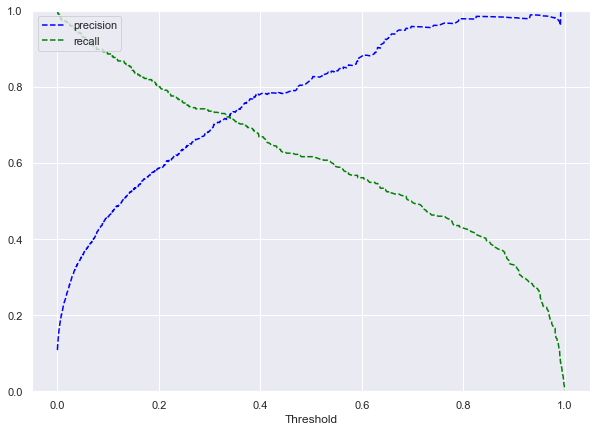

In [147]:
y_scores=lg5.predict(Xlrc_train5)
prec, rec, tre = precision_recall_curve(ylrc_train, y_scores,)

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])
plt.figure(figsize=(10,7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

####  Precision and Recall look to be balanced at ~0.32. 
### Build models trying thresholds of 0.3 - 0.45

In [148]:
scores_LRt = get_metrics_statsmodel(lg5,Xlrc_train5,Xlrc_test5,ylrc_train,ylrc_test,threshold=0.3,roc=True)

Accuracy on training set :  0.9437142857142857
Accuracy on test set :  0.9386666666666666
Recall on training set :  0.7361963190184049
Recall on test set :  0.7077922077922078
Precision on training set :  0.6837606837606838
Precision on test set :  0.6987179487179487
F1 on training set :  0.7090103397341211
F1 on test set :  0.7032258064516129
ROC-AUC Score on training set :  0.8506123372029643
ROC-AUC Score on test set :  0.8364369657088826


In [149]:
scores_LRt = get_metrics_statsmodel(lg5,Xlrc_train5,Xlrc_test5,ylrc_train,ylrc_test,threshold=0.32,roc=True)

Accuracy on training set :  0.9468571428571428
Accuracy on test set :  0.942
Recall on training set :  0.7300613496932515
Recall on test set :  0.7012987012987013
Precision on training set :  0.7083333333333334
Precision on test set :  0.7248322147651006
F1 on training set :  0.7190332326283988
F1 on test set :  0.712871287128713
ROC-AUC Score on training set :  0.8495927416393164
ROC-AUC Score on test set :  0.8354190386136895


In [150]:
scores_LRt = get_metrics_statsmodel(lg5,Xlrc_train5,Xlrc_test5,ylrc_train,ylrc_test,threshold=0.35,roc=True)

Accuracy on training set :  0.9488571428571428
Accuracy on test set :  0.946
Recall on training set :  0.7085889570552147
Recall on test set :  0.6948051948051948
Precision on training set :  0.7333333333333333
Precision on test set :  0.7588652482269503
F1 on training set :  0.7207488299531981
F1 on test set :  0.7254237288135594
ROC-AUC Score on training set :  0.8410619643499136
ROC-AUC Score on test set :  0.8347725825437564


In [151]:
scores_LRt = get_metrics_statsmodel(lg5,Xlrc_train5,Xlrc_test5,ylrc_train,ylrc_test,threshold=0.37,roc=True)

Accuracy on training set :  0.9514285714285714
Accuracy on test set :  0.9486666666666667
Recall on training set :  0.7024539877300614
Recall on test set :  0.6883116883116883
Precision on training set :  0.7582781456953642
Precision on test set :  0.7851851851851852
F1 on training set :  0.7292993630573249
F1 on test set :  0.7335640138408306
ROC-AUC Score on training set :  0.8397273089248921
ROC-AUC Score on test set :  0.8333831844233033


#### Best threshold for F1 Score - threshold - 0.4

In [152]:
scores_LRt = get_metrics_statsmodel(lg5,Xlrc_train5,Xlrc_test5,ylrc_train,ylrc_test,threshold=0.4,roc=True)

Accuracy on training set :  0.9517142857142857
Accuracy on test set :  0.9513333333333334
Recall on training set :  0.6687116564417178
Recall on test set :  0.6883116883116883
Precision on training set :  0.7813620071684588
Precision on test set :  0.8091603053435115
F1 on training set :  0.7206611570247934
F1 on test set :  0.743859649122807
ROC-AUC Score on training set :  0.8247465024489623
ROC-AUC Score on test set :  0.8348690685243433


In [153]:
scores_LRt = get_metrics_statsmodel(lg5,Xlrc_train5,Xlrc_test5,ylrc_train,ylrc_test,threshold=0.42,roc=True)

Accuracy on training set :  0.9505714285714286
Accuracy on test set :  0.9513333333333334
Recall on training set :  0.647239263803681
Recall on test set :  0.6753246753246753
Precision on training set :  0.7843866171003717
Precision on test set :  0.8188976377952756
F1 on training set :  0.7092436974789916
F1 on test set :  0.7402135231316725
ROC-AUC Score on training set :  0.8144828959220044
ROC-AUC Score on test set :  0.829118504081357


In [154]:
scores_LRt = get_metrics_statsmodel(lg5,Xlrc_train5,Xlrc_test5,ylrc_train,ylrc_test,threshold=0.45,roc=True)

Accuracy on training set :  0.9491428571428572
Accuracy on test set :  0.9513333333333334
Recall on training set :  0.6257668711656442
Recall on test set :  0.6688311688311688
Precision on training set :  0.7846153846153846
Precision on test set :  0.824
F1 on training set :  0.6962457337883959
F1 on test set :  0.7383512544802866
ROC-AUC Score on training set :  0.8040617594643595
ROC-AUC Score on test set :  0.8262432218598637


### For thresholds in the range of 0.3 - 0.45 a threshold of 0.4 yields the highest F1 score of 0.7438 as well as slightly higher Recall & ROC-AUC scores.  Precision dropped by 0.04%.

### Identifying the optimal threshold has yielded an increase of F1 by ~0.0132%

#### See how well the model performance generalizes with ROC-AUC

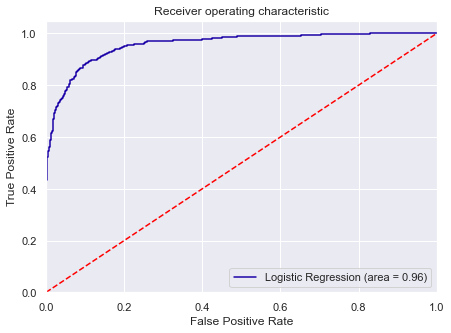

In [155]:
# ROC_AUC for lg5 training data
logit_roc_auc_train = roc_auc_score(ylrc_train, lg5.predict(Xlrc_train5))
fpr, tpr, thresholds = roc_curve(ylrc_train, lg5.predict(Xlrc_train5))
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

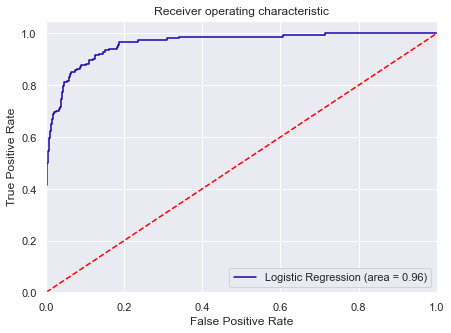

In [156]:
# ROC_AUC for lg5 testing data
logit_roc_auc_train = roc_auc_score(ylrc_test, lg5.predict(Xlrc_test5))
fpr, tpr, thresholds = roc_curve(ylrc_test, lg5.predict(Xlrc_test5))
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### ROC-AUC shows good generalized performance on both training and test sets

In [157]:
# Model prediction with optimal threshold
pred_train_opt = (lg5.predict(Xlrc_train5)>0.4).astype(int)
pred_test_opt = (lg5.predict(Xlrc_test5)>0.4).astype(int)

#Model performance with optimal threhold

print('Accuracy on train data:',accuracy_score(ylrc_train, pred_train_opt) )
print('Accuracy on test data:',accuracy_score(ylrc_test, pred_test_opt))

print('Recall on train data:',recall_score(ylrc_train, pred_train_opt))
print('Recall on test data:',recall_score(ylrc_test, pred_test_opt))

print('Precision on train data:',precision_score(ylrc_train, pred_train_opt) )
print('Precision on test data:',precision_score(ylrc_test, pred_test_opt))

print('f1 score on train data:',f1_score(ylrc_train, pred_train_opt))
print('f1 score on test data:',f1_score(ylrc_test, pred_test_opt))

Accuracy on train data: 0.9517142857142857
Accuracy on test data: 0.9513333333333334
Recall on train data: 0.6687116564417178
Recall on test data: 0.6883116883116883
Precision on train data: 0.7813620071684588
Precision on test data: 0.8091603053435115
f1 score on train data: 0.7206611570247934
f1 score on test data: 0.743859649122807


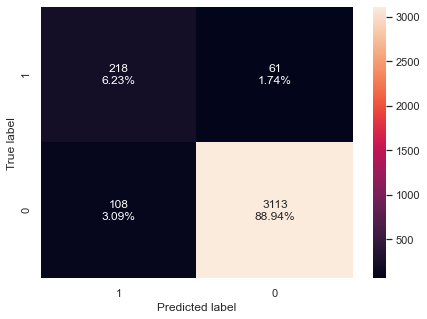

In [158]:
# Make a confusion matrix on train set
make_confusion_matrix(ylrc_train, pred_train_opt)

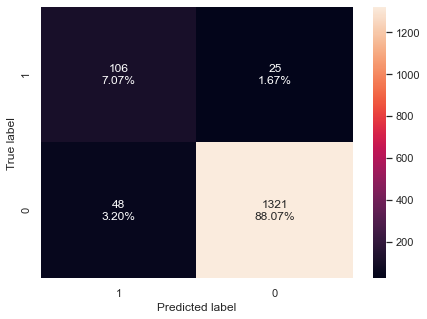

In [159]:
# Make a confusion matrix on test set
make_confusion_matrix(ylrc_test, pred_test_opt)

In [160]:
# Create DataFrame of missed predictions for later EDA
logit5_pred = pred_test_opt.copy()
logit5_actual = ylrc_test.copy()
logit5_miss_id = logit5_actual[logit5_pred != logit5_actual].index
logit5_missed = ldf_continuous.iloc[logit5_miss_id -1]
logit5_missed.head(1)

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,County
ID,,,,,,,,,,,,,
4672,39,14,104,1,4.0,3,0,0,0,1,1,1,Santa Clara County


### Metrics with final model logit5 - Threshold=0.4

#### Obserations
- logit5 with threshold=0.4 has proved to be the most balanced Logistic Regression model.
- While we were able to achieve Recall scores > 90% with other thresholds, Precision and F1 dropped significantly.

### StatsModel Review of final Logistic Regression model logit5

In [161]:
lg5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal_Loan   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3491
Method:                           MLE   Df Model:                            8
Date:                Thu, 17 Jun 2021   Pseudo R-squ.:                  0.5850
Time:                        14:37:34   Log-Likelihood:                -449.91
converged:                       True   LL-Null:                       -1084.1
Covariance Type:            nonrobust   LLR p-value:                1.569e-268
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -13.5366      0.689    -19.638      0.000     -14.888     -12.186
Income                 0.0551      0.003     17.532      0.000       0.049       0.061
Family                 0.7429      0.091      8.206      0.000       0.565       0.920
CCAvg                  0.1074      0.047      2.297      0.022       0.016       0.199
Education              1.7386      0.137     12.719      0.000       1.471       2.006
Securities_Account    -1.1314      0.361     -3.130      0.002      -1.840      -0.423
CD_Account             3.5628      0.389      9.157      0.000       2.800       4.325
Online                -0.5449      0.186     -2.924      0.003      -0.910      -0.180
CreditCard            -1.0369      0.244     -4.242      0.000      -1.516      -0.558
======================================================================================
"""

### According to the Logistic Regression model the significant variables for predicting personal loan acceptance are:
- Income, Family, CCAvg, Education, Securities_Account, CD_Account, Online, CreditCard

#### Look at coefficient change odds

In [162]:
# Calculate Look at coefficient change odds
perc_change_odds = (np.exp(lg5.params)-1)*100 # finding the percentage change
pd.set_option('display.max_columns',None) # removing limit from number of columns to display
pd.DataFrame(perc_change_odds, Xlrc_train5.columns, columns=['change_odds%']).T # adding the change_odds% to a dataframe

,const,Income,Family,CCAvg,Education,Securities_Account,CD_Account,Online,CreditCard
change_odds%,-99.999868,5.666284,110.194807,11.336157,468.927191,-67.742994,3426.160917,-42.0109,-64.545033


### Observations on coefficients change odds
1 unit change in feature if all other features remain constant:
- Income will increase the odds of someone accepting a personal loan by 5.66% 
- CCAvg will increase the odds of someone accepting a personal loan by 11.33% 
- Securities_Account will decrease the odds of someone accepting a personal loan by 67.7% 
- Online will decrease the odds of someone accepting a personal loan by 64.5%


### Compare Logistic Regression Models

In [163]:
comparison_frame = pd.DataFrame({'Linear Regression Model':['SKLearn Continuous Variables, Solver=newton-cg','SKLearn Continuous Variables, Solver=liblinear',
                                          'SKLearn Binned Variables, Solver=liblinear', 'StatsModel logit5 - Threshold=0.50', 'StatsModel logit5 - Threshold=0.63',
                                                           'StatsModel logit5 - Threshold=0.45'],
                                 'Train F1':[0.6903,0.6916,0.6935,0.7040,0.5426,0.7206], 'Test F1':[0.7238,0.7265,0.6692,0.7306,0.6034,0.7438]}) 
comparison_frame

,Linear Regression Model,Train F1,Test F1
0,"SKLearn Continuous Variables, Solver=newton-cg",0.6903,0.7238
1,"SKLearn Continuous Variables, Solver=liblinear",0.6916,0.7265
2,"SKLearn Binned Variables, Solver=liblinear",0.6935,0.6692
3,StatsModel logit5 - Threshold=0.50,0.7040,0.7306
4,StatsModel logit5 - Threshold=0.63,0.5426,0.6034
5,StatsModel logit5 - Threshold=0.45,0.7206,0.7438


## Logistic Regression Conclusion & Recommendations
- Increasing customers with higher Income, Family, CCAvg, Education & CD_Account will lead to more customers accepting a personal loan
- Decreasing customers with Securities_Accounts, Online & CreditCard will lead to less customers who are NOT likely to accept a personal loan
- **A F1 test score of 0.74** with fairly balanced Precision and Recall has been achieved to predict those who would accept a personal loan, however it may be possible to improve results by:
-- Oversampling the dependent variable
-- Increasing the size of the sample
-- Possibly include Zipcode and Target / bin through methods other than county
-- Using other machine learning models such as decision trees


### We will try and improve on the overall outcome with Decision Tree Models
We will make a copy of the previously prepared ldf_binnedEnc to use as the base data set.  

Decision Tree data set will be: **dtdf**

In [164]:
dtdf = ldf_binnedEnc.copy()

## Build Decision Tree Models

## ------------------------------dtdf-----------------------------------------------------
##   Split & build Decision Tree Model 
## -----------------------------------------------------------------------------------------

Xdtdf & ydtdf will be variables for this model 

In [165]:
# Check dataframe & shape
print(dtdf.shape)
display(dtdf.head(2))

(5000, 30)


,Family,Education,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,ExpBin,IBins,CCABin,MBins,AgeBins,County_Contra Costa County,County_County_Other,County_Kern County,County_Los Angeles County,County_Marin County,County_Monterey County,County_Orange County,County_Riverside County,County_Sacramento County,County_San Bernardino County,County_San Diego County,County_San Francisco County,County_San Mateo County,County_Santa Barbara County,County_Santa Clara County,County_Santa Cruz County,County_Ventura County,County_Yolo County
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4,1,0,1,0,0,0,1,1,3,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,0,1,0,0,0,2,1,3,1,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [166]:
dtdf['Personal_Loan'].value_counts()

0    4520
1     480
Name: Personal_Loan, dtype: int64

#### As stated in building the logistic regression models the initial sample is unbalanced, results could potentially be improved by oversampling the dataset.  Personal_Loan accepted is is ~9.6%.

### Split Data

In [167]:
Xdtdf = dtdf.drop("Personal_Loan" , axis=1)
ydtdf = dtdf.pop("Personal_Loan")

In [168]:
print(Xdtdf.shape)
print(ydtdf.shape)

(5000, 29)
(5000,)


In [169]:
Xdtdf_train, Xdtdf_test, ydtdf_train, ydtdf_test = train_test_split(Xdtdf, ydtdf, test_size=.30, random_state=2021)

#### Check the split

In [170]:
print(Xdtdf_train.shape)
print(Xdtdf_test.shape)
print(ydtdf_train.shape)
print(ydtdf_test.shape)

(3500, 29)
(1500, 29)
(3500,)
(1500,)


### Build Decision Tree Model
Using default 'gini' criterion to split.  

In [171]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=2021)
dTree.fit(Xdtdf_train, ydtdf_train)

DecisionTreeClassifier(random_state=2021)

In [172]:
ydtdf.sample(10)

ID
1092    0
1824    0
2205    0
477     0
387     0
4350    0
373     0
4514    0
2054    0
3033    0
Name: Personal_Loan, dtype: category
Categories (2, int64): [0, 1]

#### Check score

### We will continue to use F1 Score as our primary metric

In [173]:
##  Function to calculate Decision Tree scores
def get_dt_scores(model):
    pred_train = model.predict(Xdtdf_train)
    pred_test = model.predict(Xdtdf_test)
    print("Accuracy on training set : ",metrics.accuracy_score(ydtdf_train,pred_train))
    print("Accuracy on test set : ",metrics.accuracy_score(ydtdf_test,pred_test))
    print("")    
    print("Precision on training set : ",metrics.precision_score(ydtdf_train,pred_train))
    print("Precision on test set : ",metrics.precision_score(ydtdf_test,pred_test))
    print("")     
    print("Recall on training set : ",metrics.recall_score(ydtdf_train,pred_train))
    print("Recall on test set : ",metrics.recall_score(ydtdf_test,pred_test))
    print("")
    print("F1 on training set : ",metrics.f1_score(ydtdf_train,pred_train))
    print("F1 on test set : ",metrics.f1_score(ydtdf_test,pred_test))
    print("")     

In [174]:
## Function to create confusion matrix
def make_confusion_matrix_dt(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(Xdtdf_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [175]:
get_dt_scores(dTree)

Accuracy on training set :  0.9988571428571429
Accuracy on test set :  0.9686666666666667

Precision on training set :  1.0
Precision on test set :  0.8689655172413793

Recall on training set :  0.9877300613496932
Recall on test set :  0.8181818181818182

F1 on training set :  0.9938271604938271
F1 on test set :  0.8428093645484949



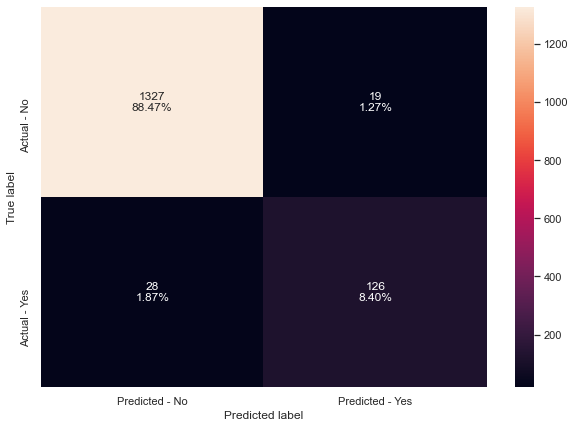

In [176]:
make_confusion_matrix_dt(dTree,ydtdf_test)

#### F1 Score score on training set is excellent and testing set is very good, but they are not well balanced so we are very likely overfitting the model.
### Lets visualize the decision tree and check it's complexity

In [177]:
feature_names1 = list(Xdtdf.columns)
print(feature_names1)

['Family', 'Education', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard', 'ExpBin', 'IBins', 'CCABin', 'MBins', 'AgeBins', 'County_Contra Costa County', 'County_County_Other', 'County_Kern County', 'County_Los Angeles County', 'County_Marin County', 'County_Monterey County', 'County_Orange County', 'County_Riverside County', 'County_Sacramento County', 'County_San Bernardino County', 'County_San Diego County', 'County_San Francisco County', 'County_San Mateo County', 'County_Santa Barbara County', 'County_Santa Clara County', 'County_Santa Cruz County', 'County_Ventura County', 'County_Yolo County']


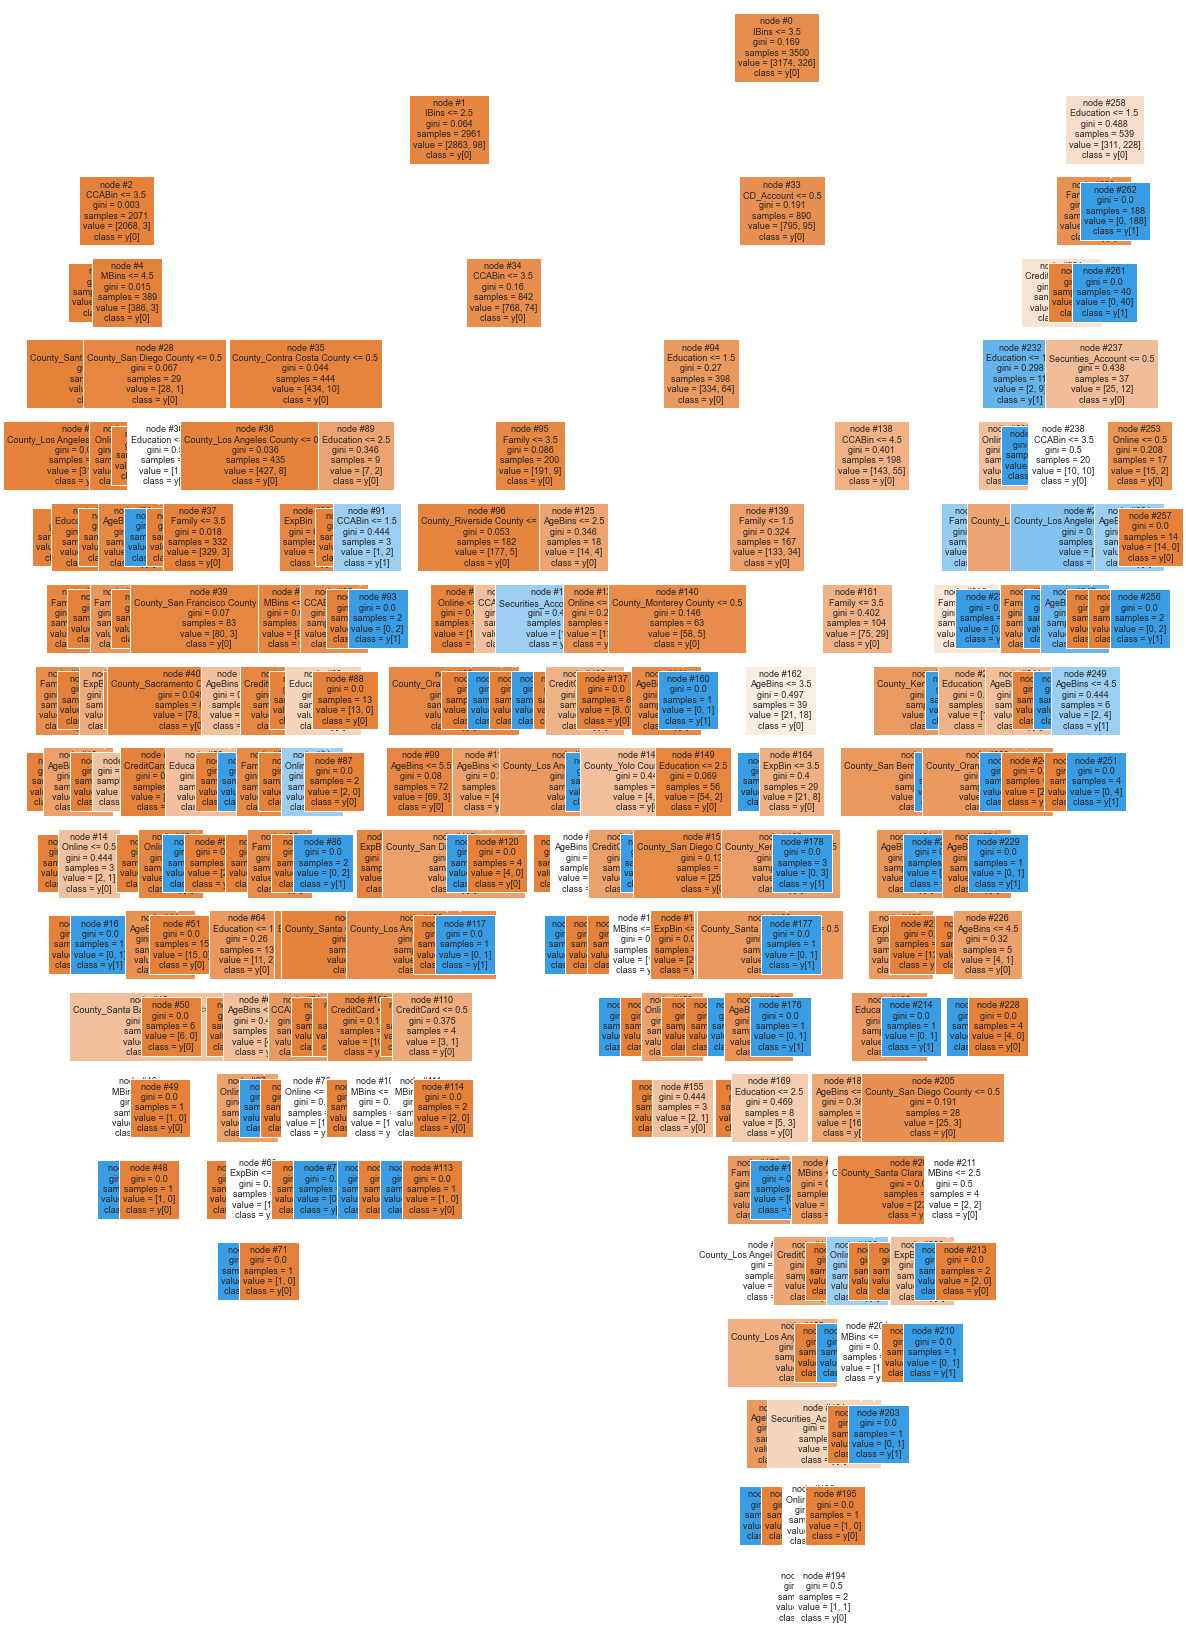

In [178]:
plt.figure(figsize=(20,30))
tree.plot_tree(dTree,feature_names=feature_names1,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

#### Examine the Gini importance

In [179]:
# Show Gini Importance
print (pd.DataFrame(dTree.feature_importances_, columns = ["Imp"], index = Xdtdf_train.columns).sort_values(by = 'Imp', ascending = False))

                                   Imp
Education                     0.368497
IBins                         0.259887
Family                        0.152317
AgeBins                       0.048652
CCABin                        0.045718
CD_Account                    0.018925
ExpBin                        0.016108
Online                        0.016098
CreditCard                    0.014178
MBins                         0.012707
County_Los Angeles County     0.008673
Securities_Account            0.007535
County_San Diego County       0.007266
County_Kern County            0.004703
County_Orange County          0.002983
County_Monterey County        0.002936
County_Santa Cruz County      0.002506
County_San Bernardino County  0.002466
County_Yolo County            0.001818
County_Santa Clara County     0.001289
County_Contra Costa County    0.001249
County_Sacramento County      0.001010
County_Riverside County       0.000973
County_San Francisco County   0.000937
County_Santa Barbara Coun

#### Visualize the Gini importances

In [180]:
feature_names = list(Xdtdf_train.columns)
print(feature_names)

['Family', 'Education', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard', 'ExpBin', 'IBins', 'CCABin', 'MBins', 'AgeBins', 'County_Contra Costa County', 'County_County_Other', 'County_Kern County', 'County_Los Angeles County', 'County_Marin County', 'County_Monterey County', 'County_Orange County', 'County_Riverside County', 'County_Sacramento County', 'County_San Bernardino County', 'County_San Diego County', 'County_San Francisco County', 'County_San Mateo County', 'County_Santa Barbara County', 'County_Santa Clara County', 'County_Santa Cruz County', 'County_Ventura County', 'County_Yolo County']


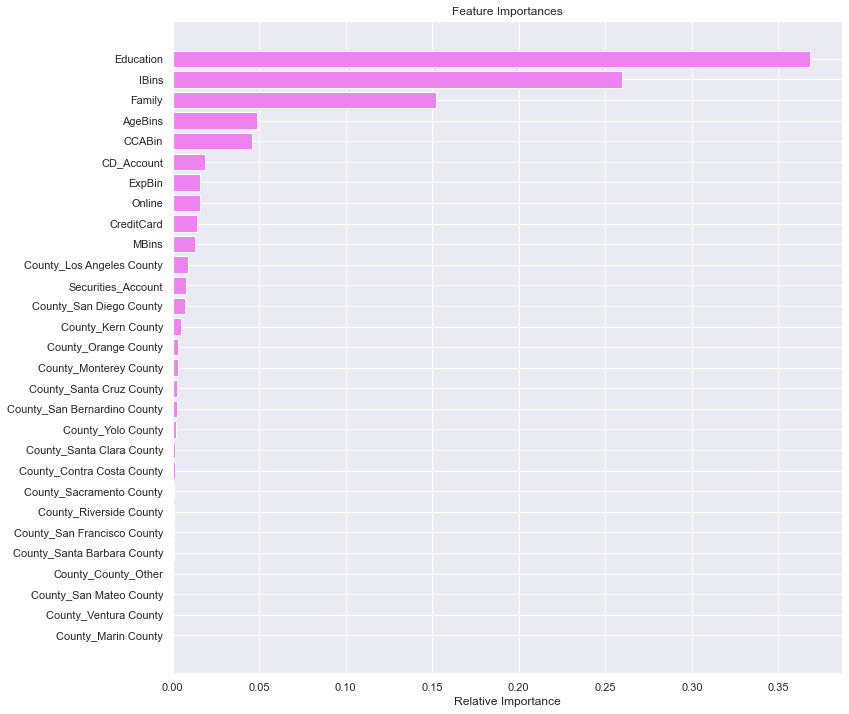

In [181]:
importances = dTree.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Education and Income are showing as the most important features in this decision tree model
#### This is a bit surprising as EDA showed that there is only a 11% difference in undergraduate and Advanced for personal loan acceptance
#### However we know that this model is overfitting so these will likely change

## Try and reduce overfitting by retraining the decision tree with a max depth of 3


In [182]:
# Train new decision dtree
dTree1 = DecisionTreeClassifier(criterion = 'gini',max_depth=3,random_state=2021)
dTree1.fit(Xdtdf_train, ydtdf_train)

DecisionTreeClassifier(max_depth=3, random_state=2021)

In [183]:
get_dt_scores(dTree1)

Accuracy on training set :  0.972
Accuracy on test set :  0.9693333333333334

Precision on training set :  1.0
Precision on test set :  1.0

Recall on training set :  0.6993865030674846
Recall on test set :  0.7012987012987013

F1 on training set :  0.8231046931407942
F1 on test set :  0.8244274809160306



#### Recall scores have dropped and F1 test scores have improved by ~2%.  Most importantly the training and testing results are more balanced so we have reduced overfitting.

#### Lets look at the tree and see how much we have reduced complexity & check what the important features are for this model

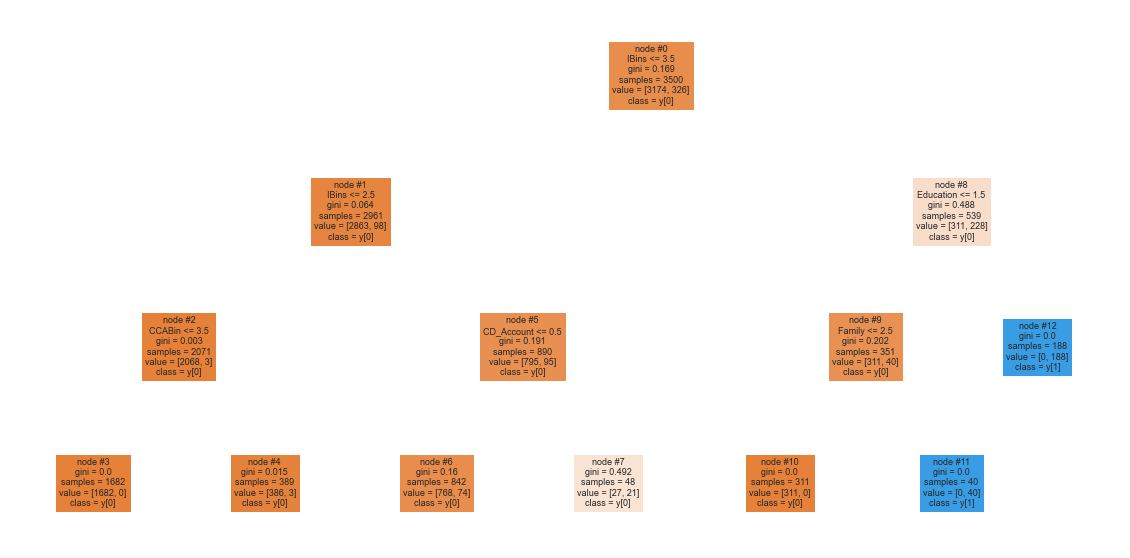

In [184]:
# Plot the decision tree
plt.figure(figsize=(20,10))
tree.plot_tree(dTree1,feature_names=feature_names1,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

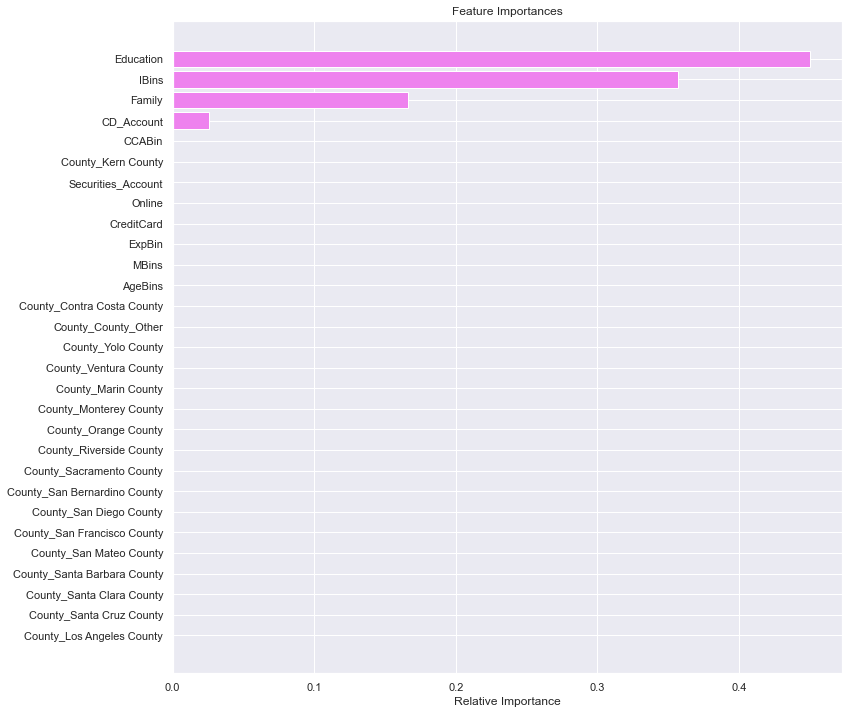

In [185]:
# check the gini importances
importances = dTree1.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Surprisingly Education, Income & Family have remained the top features for predicting.

#### While the F1 Scores are good we may be able to improve them by pruning the tree via Hyperparameter Tuning

## Hyperparameter tuning with GridSearch using F1 as the target metric
- Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.
- It is an exhaustive search that is performed on a the specific parameter values of a model.
- The parameters of the estimator/model used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [186]:
# Choose the type of classifier. 
estimator = DecisionTreeClassifier(random_state=2021)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(1,10), 
              'min_samples_leaf': [1, 2, 5, 7, 10, 15, 20],
              'max_leaf_nodes' : [2, 3, 5, 10],
              'min_impurity_decrease': [0.001, 0.01, 0.1],
              'criterion': ['gini', 'entropy'],
              'splitter': ['best','random']
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(Xdtdf_train, ydtdf_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
estimator.fit(Xdtdf_train, ydtdf_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_leaf_nodes=10,
                       min_impurity_decrease=0.001, random_state=2021)

In [187]:
get_dt_scores(estimator)

Accuracy on training set :  0.9771428571428571
Accuracy on test set :  0.9726666666666667

Precision on training set :  0.9555555555555556
Precision on test set :  0.9448818897637795

Recall on training set :  0.7914110429447853
Recall on test set :  0.7792207792207793

F1 on training set :  0.8657718120805369
F1 on test set :  0.8540925266903915



#### Hyperparameter Tuning has increased our F1 test score by ~2% and testing and training metrics overall are well balanced
#### Let see what the importance features are now

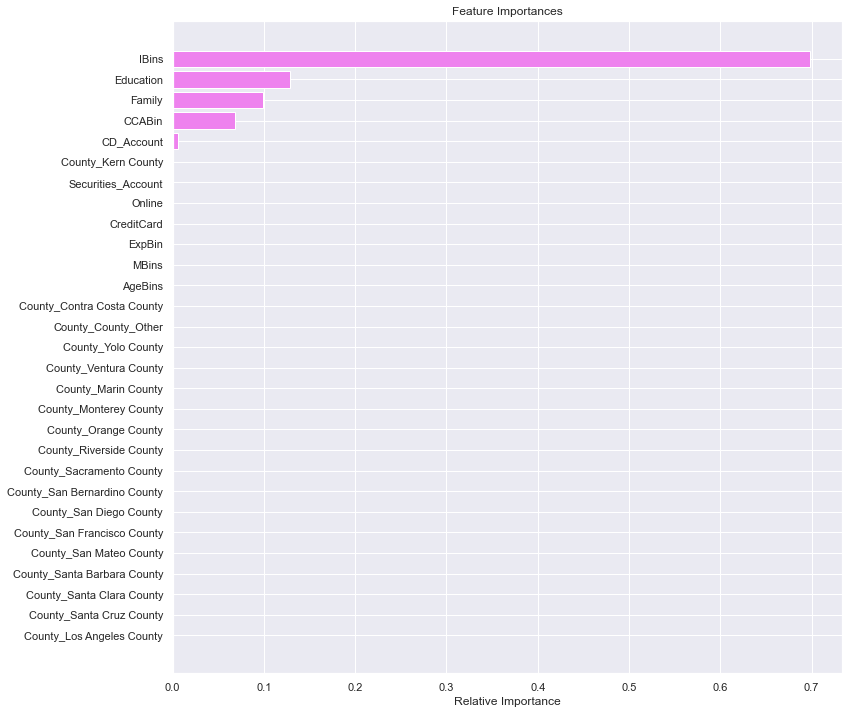

In [188]:
# visualize gini importances
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Income is now by far the most important feature, with Education, Family & Credit Card Average trailing far behind.
#### Other features are showing very little to no importance, we may be able to keep some of these and better tune the model through a different method to prune the tree.

## Cost Complexity Pruning 
Minimal cost complexity pruning recursively finds the node with the "weakest link". The weakest link is characterized by an effective alpha (ccp_alpha), where the nodes with the smallest effective alpha are pruned first.

In [189]:
# Build cost complexity 
clf = DecisionTreeClassifier(random_state=2021)
path = clf.cost_complexity_pruning_path(Xdtdf_train, ydtdf_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [190]:
pd.DataFrame(path)

,ccp_alphas,impurities
0,0.000000,0.001333
1,0.000000,0.001333
2,0.000045,0.001511
3,0.000076,0.001588
4,0.000083,0.002165
5,0.000089,0.002255
6,0.000113,0.002819
7,0.000114,0.002933
8,0.000144,0.003508
9,0.000150,0.005162


#### This shows the overall impurity of leaves vs the effective alphas.  We can visualize these to get a better idea of what is going on.

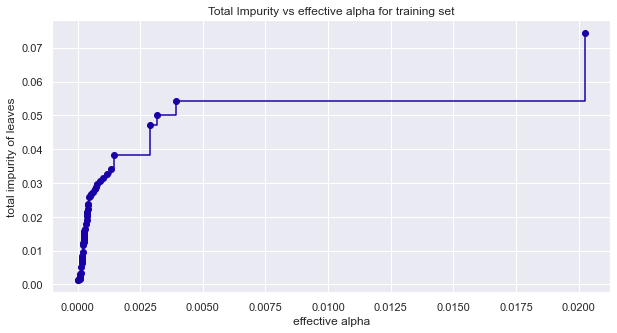

In [191]:
# visualize alphas
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

### Train a decision tree with the ccp_aphas

In [192]:
# build decision tree
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2021, ccp_alpha=ccp_alpha)
    clf.fit(Xdtdf_train, ydtdf_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.0472678091279429


#### Remove the last node & alpha, which are trivial and visualize how the number of nodes and depth of the tree progresses.

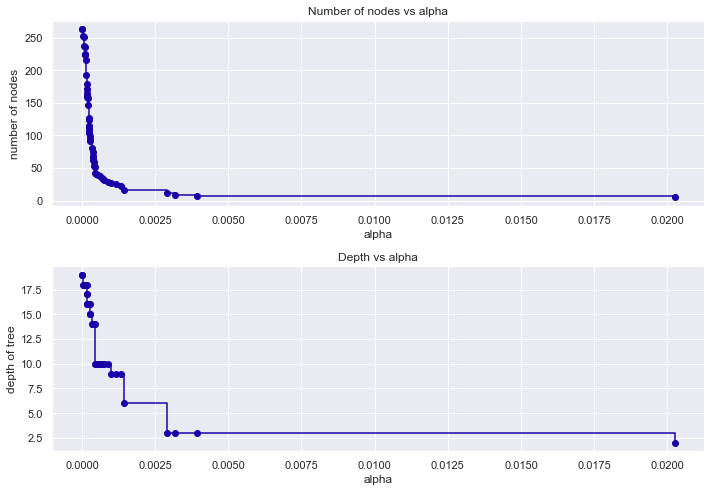

In [193]:
# Remove the last node & alpha, which are trivial and visualize how the number of nodes and depth of the tree progresses.
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1,figsize=(10,7))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

### We need to find the values for alpha and accuracy that does not overfitt the model and allows it to better generalize on testing data.

In [194]:
# get train and test scores alphas
train_scores = [clf.score(Xdtdf_train, ydtdf_train) for clf in clfs]
test_scores = [clf.score(Xdtdf_test, ydtdf_test) for clf in clfs]

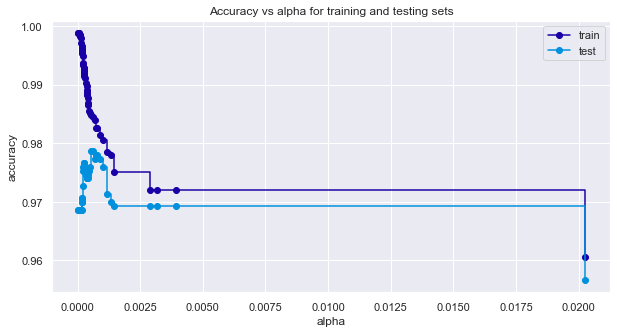

In [195]:
# plot train and test for accuracy vs alpha
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

#### Define the best model based on maximum accuracy (default)

In [196]:
# check best model results
index_best_model = np.argmax(test_scores)
best_model = clfs[index_best_model]
print(best_model)
print('Training accuracy of best model: ',best_model.score(Xdtdf_train, ydtdf_train))
print('Test accuracy of best model: ',best_model.score(Xdtdf_test, ydtdf_test))

DecisionTreeClassifier(ccp_alpha=0.0005541125541125542, random_state=2021)
Training accuracy of best model:  0.9848571428571429
Test accuracy of best model:  0.9786666666666667


#### Accuracy for testing and training is very high, accuracy is the default value for the Classifier, 
### We will want to optimize on F1, our target metric.

In [197]:
# Predict on train using F1 as the metric
f1_train=[]
for clf in clfs:
    pred_train1=clf.predict(Xdtdf_train)
    values_train=metrics.f1_score(ydtdf_train,pred_train1)
    f1_train.append(values_train)

In [198]:
# Predict on test using F1 as the metric
f1_test=[]
for clf in clfs:
    pred_test1=clf.predict(Xdtdf_test)
    values_test=metrics.f1_score(ydtdf_test,pred_test1)
    f1_test.append(values_test)

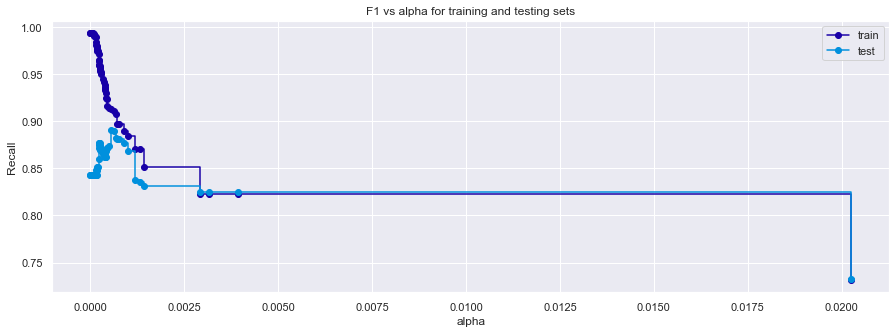

In [199]:
# plot test and train for f1 vs alpha
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("F1 vs alpha for training and testing sets")
ax.plot(ccp_alphas, f1_train, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, f1_test, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [200]:
# creating the model where we get highest test F1 Score
index_best_model = np.argmax(f1_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.0005541125541125542, random_state=2021)


####  The best model appears to have an alpha of 0.0005541
### Check the scores for best model

In [201]:
get_dt_scores(best_model)

Accuracy on training set :  0.9848571428571429
Accuracy on test set :  0.9786666666666667

Precision on training set :  0.9789473684210527
Precision on test set :  0.9420289855072463

Recall on training set :  0.8558282208588958
Recall on test set :  0.8441558441558441

F1 on training set :  0.9132569558101473
F1 on test set :  0.8904109589041096



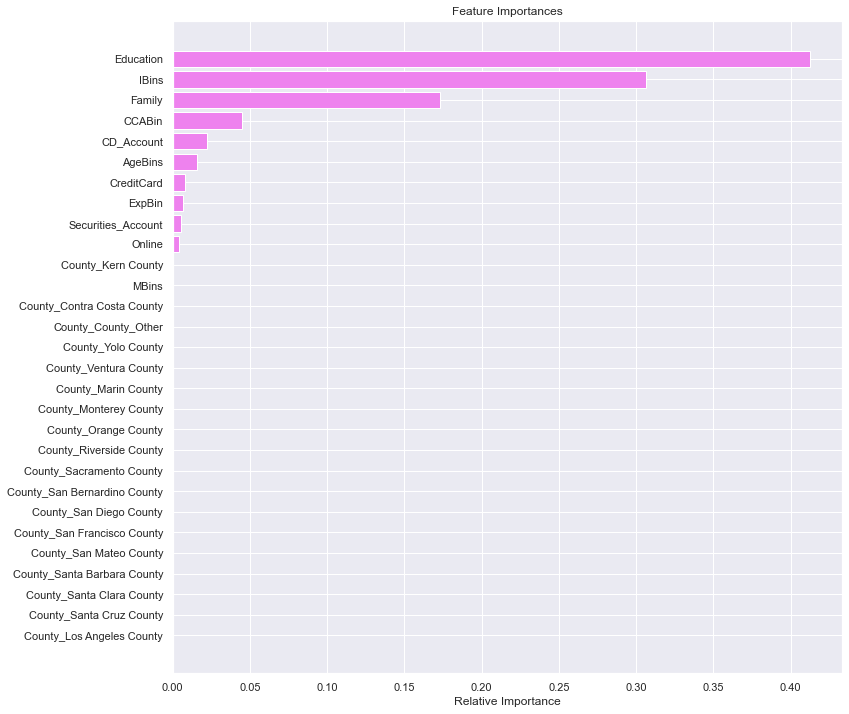

In [202]:
# visualize gini importances
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Decision Tree Conclusion & Recommendations
- Using post pruning we were able to achieve an **F1 Score on test data of 0.8904**, this is an improvement over the initial decision tree by 0.48.
- Education is the most important feature, with Income & Family being next.
- Most features other than County & Mortgage are showing some level of importance in this model.  This would likely be a better generalized model when new data is presented.
 - For the next marketing campaign identify customers with higher education & income and larger family sizes.
 - Secondary criteria would be Credit Card Averages greater than 2.3k 
 - External marketing campaigns to attract those with higher education, incomes and family sizes could bring in more customers who would be liability customers as well as personal loan customers

In [203]:
# Function to highlght pandas row
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: yellow' if is_max.any() else '' for v in is_max]

## EDA on missed predictions in model - logit5 from DF - ldf_continuous
The following is an analysis of the original data for predictions that were missed.  

In [204]:
logit5_missed.shape

(73, 13)

In [205]:
logit5_missed.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,73,NaN,NaN,NaN,43.1096,11.3927,26,33,43,50,65
Experience,73,NaN,NaN,NaN,18.0274,11.3296,1,8,18,25,40
Income,73,NaN,NaN,NaN,132.384,40.9745,60,102,122,161,218
Family,73,4,2,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CCAvg,73,NaN,NaN,NaN,3.96808,2.03432,0.2,2.8,3.67,5.4,8.8
Education,73,3,1,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mortgage,73,NaN,NaN,NaN,120.178,168.956,0,0,0,212,635
Personal_Loan,73,2,1,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Securities_Account,73,2,0,62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD_Account,73,2,0,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [206]:
# Original Sample for comparison
ldf_continuous.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,5000,NaN,NaN,NaN,45.3384,11.4632,23,35,45,55,67
Experience,5000,NaN,NaN,NaN,20.1346,11.4152,0,10,20,30,43
Income,5000,NaN,NaN,NaN,73.7742,46.0337,8,39,64,98,224
Family,5000,4,1,1472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CCAvg,5000,NaN,NaN,NaN,1.93794,1.74766,0,0.7,1.5,2.5,10
Education,5000,3,1,2096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mortgage,5000,NaN,NaN,NaN,56.4988,101.714,0,0,0,101,635
Personal_Loan,5000,2,0,4520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Securities_Account,5000,2,0,4478,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD_Account,5000,2,0,4698,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [207]:
# make a copy of missed predictions
l5 = logit5_missed.copy()

#### Age

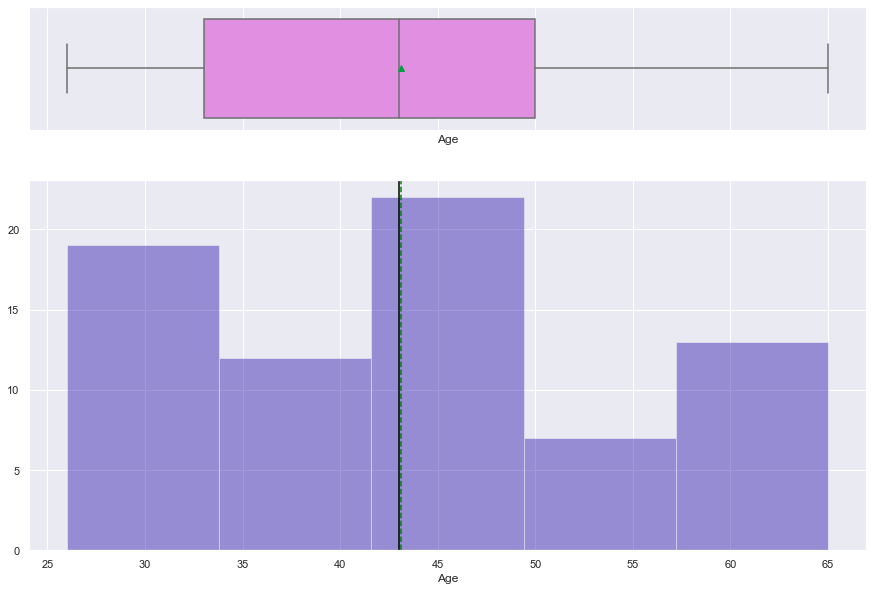

In [208]:
histogram_boxplot(l5.Age)

#### Predictions were missed across most of the range of ages with the most missed in ages 41-49 & 26 -34

#### Income

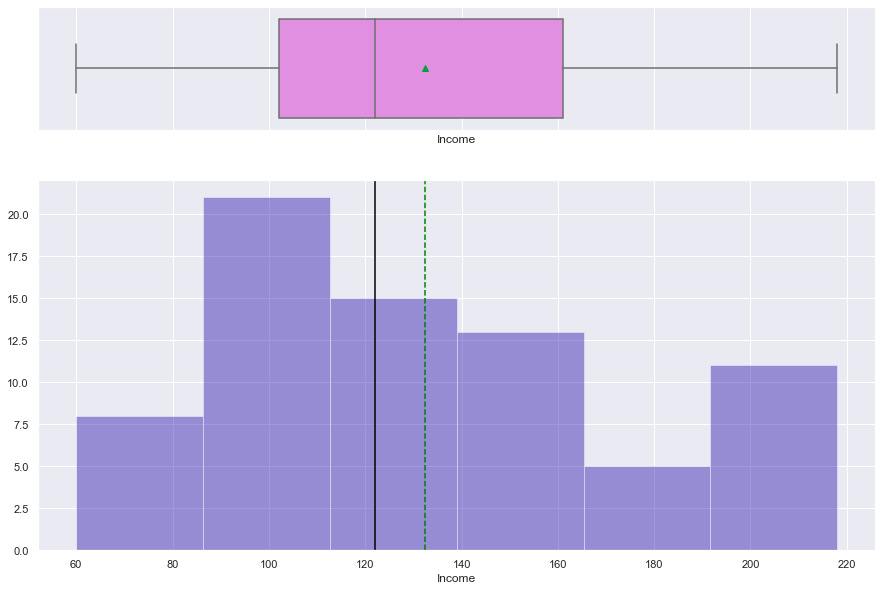

In [209]:
histogram_boxplot(l5.Income)

#### Most misses for Income are between 87k - 117k

#### Experience

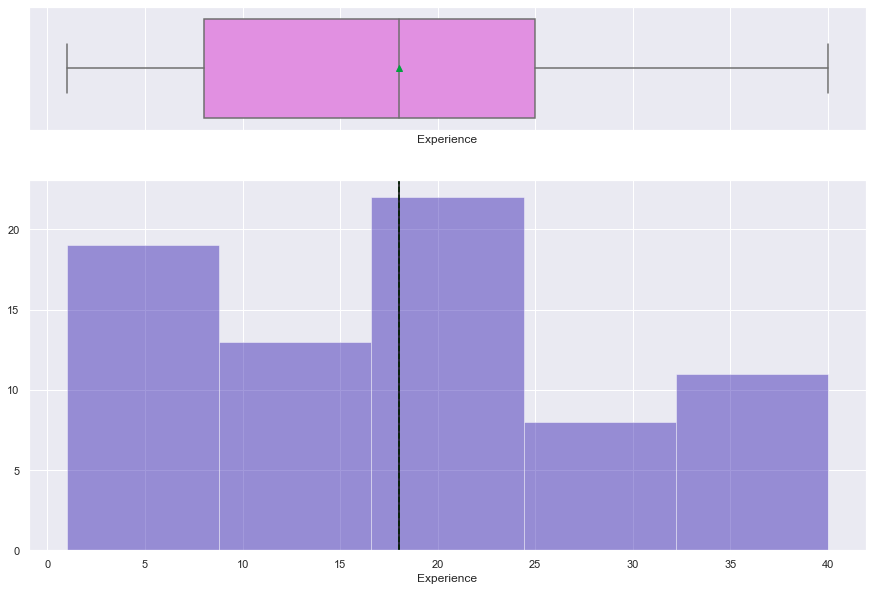

In [210]:
histogram_boxplot(l5.Experience)

#### Most msises in Experience are for 15 - 24 years

#### CCAVG

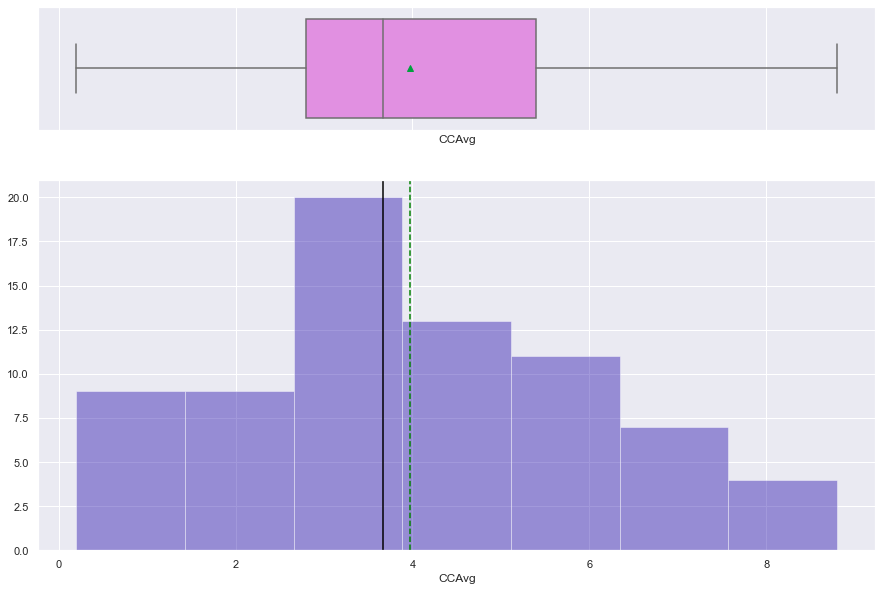

In [211]:
histogram_boxplot(l5.CCAvg)

#### Most misses in CCAvg are from 2.7k - 3.9k

#### Mortgage

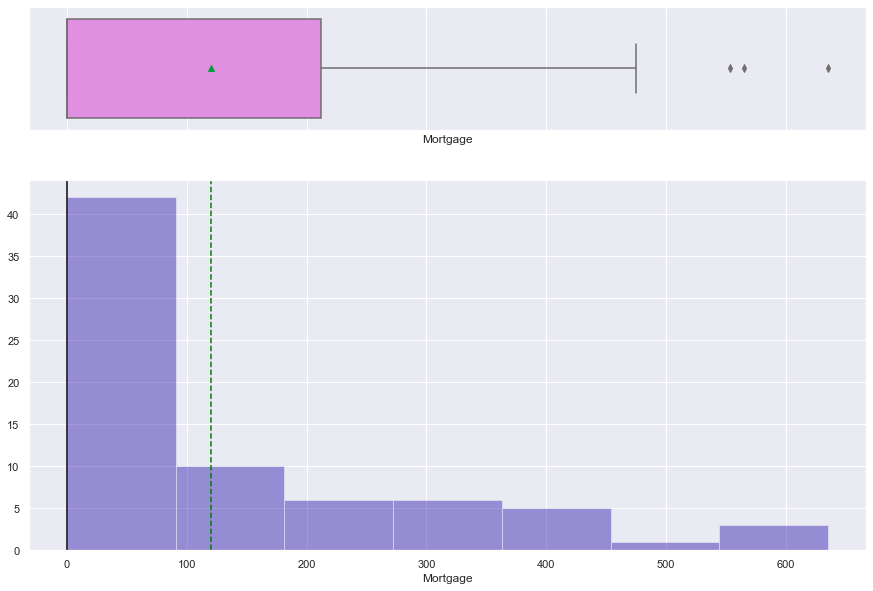

In [212]:
histogram_boxplot(l5.Mortgage)

#### Mortgage is the first to show a clear pattern with most misses by far being between 0 - 100k

#### Education

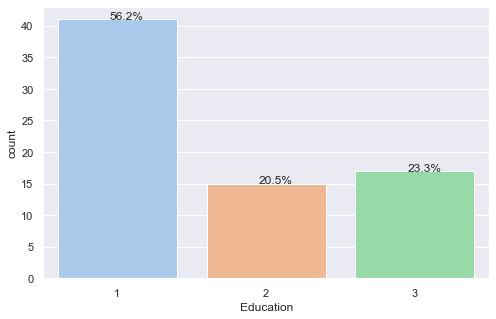

In [213]:
# plot Education
plt.figure(figsize=(8,5))
ax = sns.countplot(l5["Education"],palette='pastel')
perc_on_bar(ax,l5["Education"])

#### Education has 56% of misses in undergraduate

#### Family

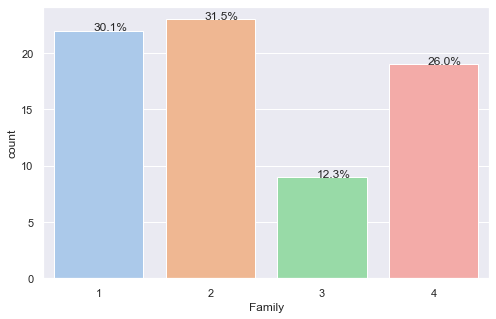

In [214]:
# plot Family
plt.figure(figsize=(8,5))
ax = sns.countplot(l5["Family"],palette='pastel')
perc_on_bar(ax,l5["Family"])

#### Family has the Least misses 12.4% in size of 3

#### County

Number of counties:  17


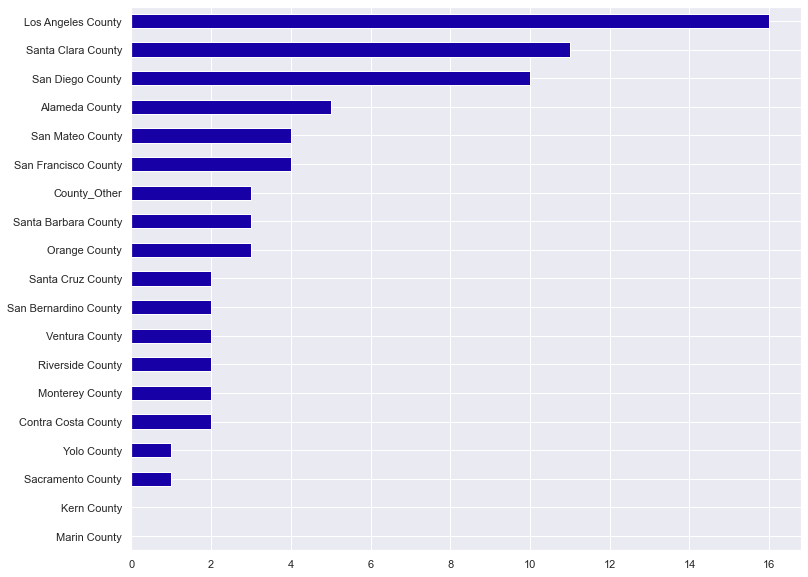

In [215]:
# Plot County
counties = l5['County'].unique()
print('Number of counties: ', len(counties))
plt.figure(figsize=(12,10))
l5['County'].value_counts().plot(kind='barh').invert_yaxis()

#### County shows no real pattern as the distribution looks fairly similar to the original sample

#### CD_Account

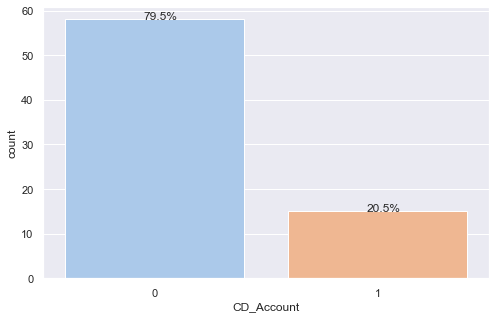

In [216]:
# plot CD_Account
plt.figure(figsize=(8,5))
ax = sns.countplot(l5["CD_Account"],palette='pastel')
perc_on_bar(ax,l5["CD_Account"])

#### CD account has 76% of misses with those who do not have an account

#### Securities Account

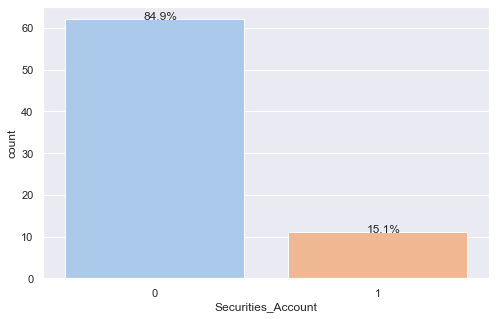

In [217]:
# plot Securities_Account
plt.figure(figsize=(8,5))
ax = sns.countplot(l5["Securities_Account"],palette='pastel')
perc_on_bar(ax,l5["Securities_Account"])

#### Most misses 85% are for those who do not have a securities account

#### Online

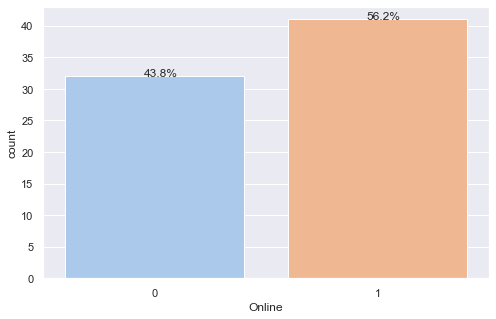

In [218]:
# plot Online
plt.figure(figsize=(8,5))
ax = sns.countplot(l5["Online"],palette='pastel')
perc_on_bar(ax,l5["Online"])

#### 56% of misses are for those who use online banking

#### Credit Card

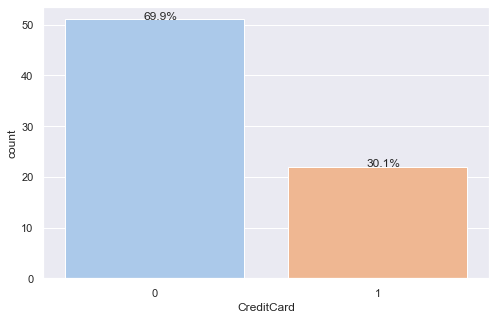

In [219]:
# plot CreditCard
plt.figure(figsize=(8,5))
ax = sns.countplot(l5["CreditCard"],palette='pastel')
perc_on_bar(ax,l5["CreditCard"])

#### 70% of misses are for those who do not have a credit card with another bank

#### Correlation Matrix

In [220]:
#Check for correlations
l5.corr()

,Age,Experience,Income,CCAvg,Mortgage
Age,1.000000,0.995523,-0.041150,-0.031938,0.070413
Experience,0.995523,1.000000,-0.016927,-0.004415,0.062788
Income,-0.041150,-0.016927,1.000000,0.528781,0.152018
CCAvg,-0.031938,-0.004415,0.528781,1.000000,-0.015057
Mortgage,0.070413,0.062788,0.152018,-0.015057,1.000000


#### Observations
- As in the original sample, Age and Experience are highly correlated
- CC Average and Income are fairly correlated
- All other features show little to no correlation


### EDA of missed predictions observations
#### No patterns stand out
Some features do initially stand out with higher or lower percentages for the misses, however when compared to the EDA from the original sample we find that the misses patterns closely match those for the original sample.

In [221]:
# Function to build model_comparison Data Frame
def model_comparison():
    
    comparison_frame = pd.DataFrame({'Model':['LR_SKLearn Continuous Variables, Solver=newton-cg',
                                                                'LR_SKLearn Continuous Variables, Solver=liblinear',
                                                                'LR_SKLearn Binned Variables, Solver=liblinear',
                                                                'LR_StatsModel logit5 - Threshold=0.50', 'StatsModel logit5 - Threshold=0.63',
                                                                'LR_StatsModel logit5 - Threshold=0.45', 
                                             'Decision Tree Initial', 'Decision Tree - Max Depth=3',
                                             'Decision Tree Hyperparameter Tuned', 'Decision Tree Post Pruned'],
                                     'Train F1':[0.6903,0.6916,0.6935,0.7040,0.5426,0.7206, 0.9938, 0.8231, 0.8657, 0.9132],
                                     'Test F1':[0.7238,0.7265,0.6692,0.7306,0.6034,0.7438, 0.8428, 0.8244, 0.8540, 0.8904]}) 
    #comparison_frame
    return comparison_frame.style.apply(highlight_greaterthan, threshold=0.86, column=['Test F1'], axis=1)

# Key Takeaways & Recommendations

### Model Observations
#### The best performing model could predict liability customers that would accept a personal loan 89.04% of the time
#### 22 models trained with F1 Score as the metric
#### Best perfroming model was - Decision Tree Post Pruned.   Results - Train F1 of 0.9132  & Test F1 of 0.8904
During EDA and feature engineering the decision was made to make 2 versions of the sample set for training.

1. Maintain continuous variables
2. Binning continuous variables
- Both sets were trained using SKLearn - Logistic Regression (solvers - newton-cg & liblinear) - **4 models**
- Both sets were trained with StatsModel - Logistic Regression (reducing complexity with VIF & P Value) -  **5 models**
- Best results from StatsModel (logit5) was tuned with various thresholds (ROC-AUC calculated & recall / precision plot) - **8 Models**
- Decision Tree training used Binned set with Hyper Parameter Tuning (GridSearchCV) & Cost Complexity Pruning - **5 models**

`note` - Initial sample set could be considered imbalanced with only 9.6% of data representing target variable, no oversampling was performed

In [222]:
model_comparison()

,Model,Train F1,Test F1
0,"LR_SKLearn Continuous Variables, Solver=newton-cg",0.690300,0.723800
1,"LR_SKLearn Continuous Variables, Solver=liblinear",0.691600,0.726500
2,"LR_SKLearn Binned Variables, Solver=liblinear",0.693500,0.669200
3,LR_StatsModel logit5 - Threshold=0.50,0.704000,0.730600
4,StatsModel logit5 - Threshold=0.63,0.542600,0.603400
5,LR_StatsModel logit5 - Threshold=0.45,0.720600,0.743800
6,Decision Tree Initial,0.993800,0.842800
7,Decision Tree - Max Depth=3,0.823100,0.824400
8,Decision Tree Hyperparameter Tuned,0.865700,0.854000
9,Decision Tree Post Pruned,0.913200,0.890400


#### Significant Variables from Logistic Regression

Income, Family, CCAvg, Education, Securities_Account, CD_Account, Online, CreditCard

#### Observations on coefficient change odds
1 unit change in feature if all other features remain constant:
- Income will increase the odds of someone accepting a personal loan by 5.66% 
- CCAvg will increase the odds of someone accepting a personal loan by 11.33% 
- Securities_Account will decrease the odds of someone accepting a personal loan by 67.7% 
- Online will decrease the odds of someone accepting a personal loan by 64.5%

#### Decision Tree Gini Importance for features
- Education is the most important feature, with Income & Family being next.
- Most features other than County & Mortgage are showing some level of importance in this model.  This would likely be a better generalized model when new data is presented.

#### EDA of missed predictions observations
**No patterns stand out.**  Some features do initially stand out with higher or lower percentages for the misses, however when compared to the EDA from the original sample we find that the misses patterns closely match those for the original sample.

## Recommendations
#### Generally, customers who use more of the banks services and have have higher averages for those services were more likely to have accepted a personal loan. This makes some sense as most of these customers have higher debt with AllLife Bank and may be more willing to extend that debt further. These same customers also tend to have higher incomes. 
 - For the next marketing campaign identify customers with higher education, income and larger family sizes.
 - External marketing campaigns to attract those with higher education, incomes and family sizes could bring in more customers who would be liability customers as well as personal loan customers
 
- Target incomes above 100k
- Target CCAvg > 3.5k
- Target customers with CD_Accounts
- Target Mortgages above 200K
- Examine customers in Santa Clara County more closely and possibly market heavier to them.
- Marketing other services, such as CD_Accoutns, could increase willingness to accept a personal loan
- Extend the types of data used to predict personal loan acceptance - such as spending patterns, savings & balances for other services.